# Duck Egg Quality Classification Based on its Shell Visual Property through Image Processing and Deep Learning


Group CGM: <br>

Caguioa, JV Bryan <br>
Guinto, Ryhle Nodnyhlson <br>
Mesias, Lee Reuben

# References

https://thedatafrog.com/en/articles/image-recognition-transfer-learning/ <br>
https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538 <br>
https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python

## Imports

In [1]:
# for image name
import random

# define and move to dataset and model directory
import os
# the directory where the data is stored
directory = "C:/Users/user/Desktop/Dataset"
#directory where set of models per training are stored
gen_dir = "C:/Users/user/Desktop/Model"

# duplicate combined image to other directory and delete directory with its content
import shutil

#for stopping code if not the right amount of images
import sys

#histograph/confusion matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

#model creation
import tensorflow.keras as keras

import numpy as np

# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#k-fold cross validation
import pandas as pd                                     #store all images and their class/label
from sklearn.model_selection import StratifiedKFold     
from sklearn.model_selection import train_test_split    #split the dataset to train-test
import tensorflow as tf                                 #for callbacks

#for model evaluation
from tensorflow.keras.preprocessing import image as im                   #load image
from tensorflow.keras.applications.resnet50 import preprocess_input      #preprocess image                                                               
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc       
from sklearn.metrics import roc_auc_score
from scipy import interp                            #interpolation needed for plotting all classes into one roc plot
from itertools import cycle                         #for the color of lines on that multiclass plot

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#validating misclassified images
import cv2     #load the image

## Put Dataset in a Dataframe

The directory of the images are put in a dataframe in order to prepare for splitting the dataset into train and test set.

In [2]:
totaldsdirect = directory + "/CombinedTwoAngleEggs"

image = []

if not os.path.exists(totaldsdirect):
    print("Directory does not exist. Please run the code on data cleaning notebook.")
    sys.exit()

for x in os.listdir(totaldsdirect):
    totaldsdirect2 = totaldsdirect + "/" + x
    for y in os.listdir(totaldsdirect2):
        if x == "Balut-penoy2":
            lbl = "0"
        elif x == "Salted egg2":
            lbl = "1"
        else:
            lbl = "2"
                 
        #append to image array
        image.append([totaldsdirect2 + "/" + y,lbl])

In [3]:
df = pd.DataFrame(image,columns=['filename','label'])
df

filename label
0    C:/Users/user/Desktop/Dataset/CombinedTwoAngle...     0
1    C:/Users/user/Desktop/Dataset/CombinedTwoAngle...     0
2    C:/Users/user/Desktop/Dataset/CombinedTwoAngle...     0
3    C:/Users/user/Desktop/Dataset/CombinedTwoAngle...     0
4    C:/Users/user/Desktop/Dataset/CombinedTwoAngle...     0
..                                                 ...   ...
595  C:/Users/user/Desktop/Dataset/CombinedTwoAngle...     2
596  C:/Users/user/Desktop/Dataset/CombinedTwoAngle...     2
597  C:/Users/user/Desktop/Dataset/CombinedTwoAngle...     2
598  C:/Users/user/Desktop/Dataset/CombinedTwoAngle...     2
599  C:/Users/user/Desktop/Dataset/CombinedTwoAngle...     2

[600 rows x 2 columns]

Classes: <br>
0 - Balut/Penoy <br> 
1 - Salted <br>
2 - Table

## Split Data to train and test set

We will need to split the dataset to train and test set. Only the train set will be used for transfer learning with K-fold validation. Test set will be used for model prediction and use that for model evaluation. Stratify is used in order to split the data in equal numbers under the classes specified.

In [4]:
# Split the data to train and test
X = df[['filename']]
y = df[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=420)

Save the split sets to train and test set folders.

In [5]:
#folder to store the train and test set folders
fortraintest = directory + "/ToBeUsed"
if not os.path.exists(fortraintest):
    os.makedirs(fortraintest)

#train set folder
tr = fortraintest + "/train_set"
if not os.path.exists(tr):
    os.makedirs(tr)
else:
    #remove previous folder and create new one
    shutil.rmtree(tr)
    os.makedirs(tr)
    
#test set folder
te = fortraintest + "/test_set"
if not os.path.exists(te):
    os.makedirs(te)
else:
    #remove previous folder and create new one
    shutil.rmtree(te)
    os.makedirs(te)

#copying the images to the train set folder
for index, row in X_train.iterrows():
    trcpy = shutil.copy2(row['filename'], tr)
    X_train.loc[X_train['filename']==row['filename'],'filename']=trcpy #change to directory where image is copied
    
#copying the images to the test set folder
for index, row in X_test.iterrows():
    tecpy = shutil.copy2(row['filename'], te)
    X_test.loc[X_test['filename']==row['filename'],'filename']=tecpy #change to directory where image is copiedb

C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [6]:
df2 = pd.concat([X_train,y_train],axis=1)
df2

filename label
11   C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...     0
581  C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...     2
377  C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...     1
487  C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...     2
216  C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...     1
..                                                 ...   ...
273  C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...     1
486  C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...     2
86   C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...     0
200  C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...     1
538  C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...     2

[540 rows x 2 columns]

## Data Augmentation

We will apply data augmentation of the dataset per epoch in order to increase the accuracy of the models

In [7]:
resnet50 = keras.applications.resnet50

imgdatagen = ImageDataGenerator(
        preprocessing_function = resnet50.preprocess_input,
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = 10,
        height_shift_range = 10,
        rotation_range = 5,
        brightness_range = [0.8,1.3],
        fill_mode = "nearest"
    )

## Create Plot History

Plot history will display the training and validation accuracy, and training and validation loss in every epoch in a fold.

In [8]:
def plot_history(history, yrange):
    #Plot loss and accuracy as a function of the epoch,
    #for the training and validation datasets.
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train_loss','val_loss'])
    
    plt.show() 

## Save Models

K-fold cross validation will be used in training the model.The set of models produced per fold will be saved in an automatic generated folder. Every training will generated another folder to save the new set of models.

In [9]:
def savemodel():
    save_cur = ""  #check if there is any saved_models folders

    svnum = 0
    svnum2 = 0

    for x in os.listdir(gen_dir):
        if "saved_models" in x:
            save_cur = x
            if not save_cur == "":
                for word in save_cur.split("_"):
                    if word.isdigit():
                        svnum2 = int(word)
                        if svnum < svnum2:
                            svnum = svnum2


    #save_dir is where the created models using the current set of parameters are added        
    if save_cur == "":
        save_dir = gen_dir + "/saved_models_1"
        os.makedirs(save_dir)
    else:
        save_dir = gen_dir + "/saved_models_" + str(svnum + 1)
        os.makedirs(save_dir)
        
    return save_dir

## Model Creation

The model will be based on ResNet50 Architecture. The classifier block will be changed to suit to our dataset.

In [10]:
def model():
    conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

    for layer in conv_model.layers:
        layer.trainable = False

    x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    predictions = keras.layers.Dense(3, activation='softmax')(x)

    full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

    return full_model

In [11]:
full_model = model()
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
stopper

NameError: name 'stopper' is not defined

## Hyper-Parameter Tuning

We will check the parameters that yielded the best results. A set of values on chosen parameters is given. The one that will yield the best results will be used for prediction.

### Model Parameters

In [31]:
#kfold parameters
Y = df2[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 69, shuffle = True)

#initialize parameters
VALIDATION_ACCURACY = []                          #holds all validation_accuracy
VALIDATION_LOSS = []                              #holds all validation_loss

TRAIN_ACCURACY = []                               #holds all train_accuracy
TRAIN_LOSS = []                                   #holds all train_loss

TEST_ACCURACY = []                                #holds all test_accuracy
TEST_LOSS = []                                    #holds all test_loss

image_dir = directory + "/ToBeUsed/train_set"     #where the train set images are stored
batch_size_arr = [8]                              #batch size
num_epochs_arr = [70,80,90]                       #number of epochs
lr_arr = [0.0001]                                 #learning rate Adamax


param_arr = []                                    #holds the parameter values per combination

val_acc_arr = []                                  #holds the set of validation accuracy per combination
val_loss_arr = []                                 #holds the set of validation loss per combination
val_acc_means = []                                #holds the means of all set of validation accuracy per combination
val_loss_means = []                               #holds the means of all set of validation loss per combination

train_acc_arr = []                                #holds the set of train accuracy per combination
train_loss_arr = []                               #holds the set of train loss per combination
train_acc_means = []                              #holds the means of all set of train accuracy per combination
train_loss_means = []                             #holds the means of all set of train loss per combination

test_acc_arr = []                                 #holds the set of test accuracy per combination
test_loss_arr = []                                #holds the set of test loss per combination
test_acc_means = []                               #holds the means of all set of test accuracy per combination
test_loss_means = []                              #holds the means of all set of test loss per combination

Train the model per combination of parameters.


batch size:  8
epochs:  70
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/70
54/54 [==============================] - 12s 174ms/step - loss: 1.1299 - accuracy: 0.4676 - val_loss: 1.1656 - val_accuracy: 0.3889

Epoch 00001: val_accuracy improved from -inf to 0.38889, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/70
54/54 [==============================] - 9s 169ms/step - loss: 0.7969 - accuracy: 0.6505 - val_loss: 0.9965 - val_accuracy: 0.4352

Epoch 00002: val_accuracy improved from 0.38889 to 0.43519, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 3/70
54/54 [==============================] - 8s 144ms/step - loss: 0.7691 - accuracy: 0.6667 - val_loss: 0.7988 - val_accuracy: 0.6111

Epoch 00003: val_accuracy improved from 0.43519 to 0.61111, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 4/70
54/54 [==============================] - 8s 143ms/step - loss: 0.6845 - accuracy: 0.7269 - val_loss: 0.7463 - val_accuracy: 0.7407

Epoch 00004: val_accuracy improved from 0.61111 to 0.74074, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_1.h5
Epoch 5/70
54/54 [==============================] - 8s 142ms/step - loss: 0.7190 - accuracy: 0.6829 - val_loss: 0.6427 - val_accuracy: 0.7222

Epoch 00005: val_accuracy did not impr

54/54 [==============================] - 11s 211ms/step - loss: 0.4399 - accuracy: 0.8333 - val_loss: 0.4538 - val_accuracy: 0.8056

Epoch 00040: val_accuracy did not improve from 0.87037
Epoch 41/70
54/54 [==============================] - 11s 209ms/step - loss: 0.4675 - accuracy: 0.8009 - val_loss: 0.5110 - val_accuracy: 0.7500

Epoch 00041: val_accuracy did not improve from 0.87037
Epoch 42/70
54/54 [==============================] - 8s 152ms/step - loss: 0.5257 - accuracy: 0.7986 - val_loss: 0.5744 - val_accuracy: 0.7593

Epoch 00042: val_accuracy did not improve from 0.87037
Epoch 43/70
54/54 [==============================] - 10s 176ms/step - loss: 0.4392 - accuracy: 0.8403 - val_loss: 0.3832 - val_accuracy: 0.8704

Epoch 00043: val_accuracy did not improve from 0.87037
Epoch 44/70
54/54 [==============================] - 10s 176ms/step - loss: 0.4505 - accuracy: 0.8056 - val_loss: 0.4725 - val_accuracy: 0.8056

Epoch 00044: val_accuracy did not improve from 0.87037
Epoch 45/70
5

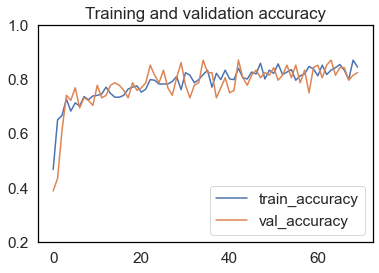

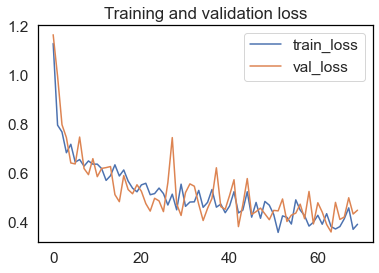

14/14 [==============================] - 2s 133ms/step - loss: 0.4152 - accuracy: 0.8333

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/70
54/54 [==============================] - 12s 165ms/step - loss: 0.9007 - accuracy: 0.6088 - val_loss: 1.0063 - val_accuracy: 0.5185

Epoch 00001: val_accuracy improved from -inf to 0.51852, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_2.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/70
54/54 [==============================] - 11s 196ms/step - loss: 0.8134 - accuracy: 0.6528 - val_loss: 0.9250 - val_accuracy: 0.5648

Epoch 00002: val_accuracy improved from 0.51852 to 0.56481, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_2.h5
Epoch 3/70
54/54 [==============================] - 11s 197ms/step - loss: 0.7250 - accuracy: 0.6759 - val_loss: 0.8481 - val_accuracy: 0.6019

Epoch 00003: val_accuracy improved from 0.56481 to 0.60185, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_2.h5
Epoch 4/70
54/54 [==============================] - 10s 188ms/step - loss: 0.7510 - accuracy: 0.6574 - val_loss: 0.7972 - val_accuracy: 0.6019

Epoch 00004: val_accuracy did not improve from 0.60185
Epoch 5/70
54/54 [==============================] - 11s 198ms/step - loss: 0.7121 - accuracy: 0.7037 - val_loss: 0.7270 - val_accuracy: 0.6667

Epoch 00005: val_accuracy improved from 0.60185 to 0.66667, saving model to C:/Users/user/Desktop/Model/saved

54/54 [==============================] - 10s 190ms/step - loss: 0.4467 - accuracy: 0.8102 - val_loss: 0.6347 - val_accuracy: 0.7130

Epoch 00040: val_accuracy did not improve from 0.82407
Epoch 41/70
54/54 [==============================] - 10s 178ms/step - loss: 0.4934 - accuracy: 0.8194 - val_loss: 0.5629 - val_accuracy: 0.7870

Epoch 00041: val_accuracy did not improve from 0.82407
Epoch 42/70
54/54 [==============================] - 10s 180ms/step - loss: 0.4229 - accuracy: 0.8194 - val_loss: 0.4490 - val_accuracy: 0.7963

Epoch 00042: val_accuracy did not improve from 0.82407
Epoch 43/70
54/54 [==============================] - 10s 178ms/step - loss: 0.4226 - accuracy: 0.8148 - val_loss: 0.5380 - val_accuracy: 0.7778

Epoch 00043: val_accuracy did not improve from 0.82407
Epoch 44/70
54/54 [==============================] - 9s 172ms/step - loss: 0.4265 - accuracy: 0.8148 - val_loss: 0.5663 - val_accuracy: 0.7685

Epoch 00044: val_accuracy did not improve from 0.82407
Epoch 45/70
5

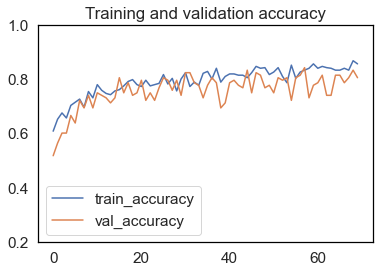

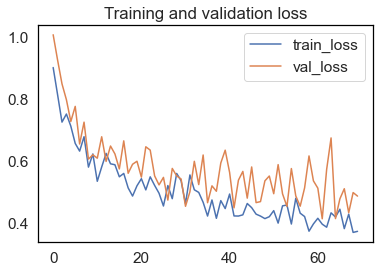

14/14 [==============================] - 2s 111ms/step - loss: 0.4434 - accuracy: 0.8426

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/70
54/54 [==============================] - 13s 191ms/step - loss: 1.1501 - accuracy: 0.4792 - val_loss: 0.9245 - val_accuracy: 0.6204

Epoch 00001: val_accuracy improved from -inf to 0.62037, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_3.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/70
54/54 [==============================] - 9s 173ms/step - loss: 0.8642 - accuracy: 0.6389 - val_loss: 0.8174 - val_accuracy: 0.6852

Epoch 00002: val_accuracy improved from 0.62037 to 0.68519, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_3.h5
Epoch 3/70
54/54 [==============================] - 9s 162ms/step - loss: 0.8301 - accuracy: 0.6366 - val_loss: 0.7896 - val_accuracy: 0.6667

Epoch 00003: val_accuracy did not improve from 0.68519
Epoch 4/70
54/54 [==============================] - 10s 182ms/step - loss: 0.7082 - accuracy: 0.6898 - val_loss: 0.7208 - val_accuracy: 0.7315

Epoch 00004: val_accuracy improved from 0.68519 to 0.73148, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_3.h5
Epoch 5/70
54/54 [==============================] - 10s 182ms/step - loss: 0.7114 - accuracy: 0.6944 - val_loss: 0.6702 - val_accuracy: 0.6944

Epoch 00005: val_accuracy did not improve from 0.73148
Epoch 6/70
54/54 [==============================] - 11s 

54/54 [==============================] - 10s 182ms/step - loss: 0.4880 - accuracy: 0.8148 - val_loss: 0.4731 - val_accuracy: 0.7870

Epoch 00040: val_accuracy did not improve from 0.85185
Epoch 41/70
54/54 [==============================] - 10s 181ms/step - loss: 0.4805 - accuracy: 0.8079 - val_loss: 0.5721 - val_accuracy: 0.7870

Epoch 00041: val_accuracy did not improve from 0.85185
Epoch 42/70
54/54 [==============================] - 10s 183ms/step - loss: 0.4838 - accuracy: 0.7847 - val_loss: 0.5688 - val_accuracy: 0.7685

Epoch 00042: val_accuracy did not improve from 0.85185
Epoch 43/70
54/54 [==============================] - 10s 189ms/step - loss: 0.4581 - accuracy: 0.8102 - val_loss: 0.4865 - val_accuracy: 0.7870

Epoch 00043: val_accuracy did not improve from 0.85185
Epoch 44/70
54/54 [==============================] - 10s 182ms/step - loss: 0.4403 - accuracy: 0.8125 - val_loss: 0.5271 - val_accuracy: 0.7870

Epoch 00044: val_accuracy did not improve from 0.85185
Epoch 45/70


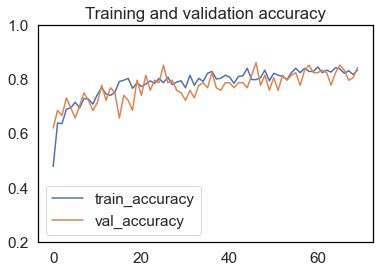

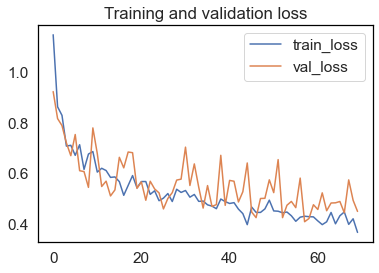

14/14 [==============================] - 2s 136ms/step - loss: 0.4238 - accuracy: 0.8333

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/70
54/54 [==============================] - 13s 187ms/step - loss: 0.9811 - accuracy: 0.5810 - val_loss: 1.0720 - val_accuracy: 0.3981

Epoch 00001: val_accuracy improved from -inf to 0.39815, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/70
54/54 [==============================] - 8s 153ms/step - loss: 0.8169 - accuracy: 0.6227 - val_loss: 0.9435 - val_accuracy: 0.4815

Epoch 00002: val_accuracy improved from 0.39815 to 0.48148, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5
Epoch 3/70
54/54 [==============================] - 10s 181ms/step - loss: 0.7875 - accuracy: 0.6505 - val_loss: 0.8074 - val_accuracy: 0.5926

Epoch 00003: val_accuracy improved from 0.48148 to 0.59259, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5
Epoch 4/70
54/54 [==============================] - 9s 169ms/step - loss: 0.7502 - accuracy: 0.6690 - val_loss: 0.7387 - val_accuracy: 0.7130

Epoch 00004: val_accuracy improved from 0.59259 to 0.71296, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5
Epoch 5/70
54/54 [==============================] - 9s 173ms/step - loss: 0.7140 - accuracy: 0.6690 - val_loss: 0.6616 - val_accuracy: 0.7778

Epoch 00005: val_accuracy improved fr

54/54 [==============================] - 9s 168ms/step - loss: 0.4486 - accuracy: 0.8241 - val_loss: 0.4180 - val_accuracy: 0.8611

Epoch 00040: val_accuracy improved from 0.84259 to 0.86111, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_4.h5
Epoch 41/70
54/54 [==============================] - 9s 167ms/step - loss: 0.4414 - accuracy: 0.8194 - val_loss: 0.4130 - val_accuracy: 0.8241

Epoch 00041: val_accuracy did not improve from 0.86111
Epoch 42/70
54/54 [==============================] - 10s 182ms/step - loss: 0.4640 - accuracy: 0.8032 - val_loss: 0.4315 - val_accuracy: 0.8148

Epoch 00042: val_accuracy did not improve from 0.86111
Epoch 43/70
54/54 [==============================] - 10s 182ms/step - loss: 0.4316 - accuracy: 0.8102 - val_loss: 0.4249 - val_accuracy: 0.8333

Epoch 00043: val_accuracy did not improve from 0.86111
Epoch 44/70
54/54 [==============================] - 10s 189ms/step - loss: 0.4396 - accuracy: 0.8287 - val_loss: 0.4274 - val_accuracy: 0.

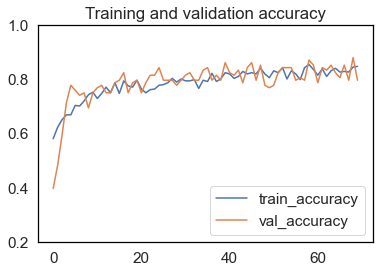

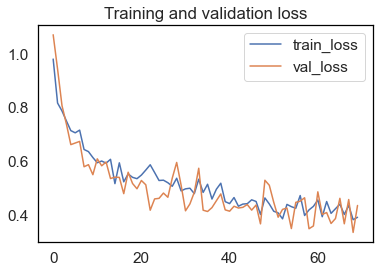

14/14 [==============================] - 2s 136ms/step - loss: 0.3553 - accuracy: 0.85190s - loss: 0.3553 - accuracy: 0.85

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/70
54/54 [==============================] - 13s 175ms/step - loss: 1.1399 - accuracy: 0.4792 - val_loss: 1.3012 - val_accuracy: 0.4352

Epoch 00001: val_accuracy improved from -inf to 0.43519, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_5.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/70
54/54 [==============================] - 9s 160ms/step - loss: 0.9488 - accuracy: 0.5394 - val_loss: 0.8997 - val_accuracy: 0.5926

Epoch 00002: val_accuracy improved from 0.43519 to 0.59259, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_5.h5
Epoch 3/70
54/54 [==============================] - 9s 164ms/step - loss: 0.7995 - accuracy: 0.6782 - val_loss: 0.7825 - val_accuracy: 0.6481

Epoch 00003: val_accuracy improved from 0.59259 to 0.64815, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_5.h5
Epoch 4/70
54/54 [==============================] - 9s 173ms/step - loss: 0.8068 - accuracy: 0.6296 - val_loss: 0.7014 - val_accuracy: 0.6852

Epoch 00004: val_accuracy improved from 0.64815 to 0.68519, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_5.h5
Epoch 5/70
54/54 [==============================] - 10s 178ms/step - loss: 0.7310 - accuracy: 0.6852 - val_loss: 0.6401 - val_accuracy: 0.7315

Epoch 00005: val_accuracy improved fr

54/54 [==============================] - 9s 161ms/step - loss: 0.4914 - accuracy: 0.7870 - val_loss: 0.4150 - val_accuracy: 0.8056

Epoch 00039: val_accuracy did not improve from 0.86111
Epoch 40/70
54/54 [==============================] - 9s 161ms/step - loss: 0.5131 - accuracy: 0.7894 - val_loss: 0.3369 - val_accuracy: 0.8796

Epoch 00040: val_accuracy improved from 0.86111 to 0.87963, saving model to C:/Users/user/Desktop/Model/saved_models_1\model_5.h5
Epoch 41/70
54/54 [==============================] - 9s 165ms/step - loss: 0.5257 - accuracy: 0.7708 - val_loss: 0.3994 - val_accuracy: 0.8148

Epoch 00041: val_accuracy did not improve from 0.87963
Epoch 42/70
54/54 [==============================] - 10s 175ms/step - loss: 0.4557 - accuracy: 0.8171 - val_loss: 0.3477 - val_accuracy: 0.8333

Epoch 00042: val_accuracy did not improve from 0.87963
Epoch 43/70
54/54 [==============================] - 8s 148ms/step - loss: 0.4902 - accuracy: 0.8032 - val_loss: 0.3955 - val_accuracy: 0.83

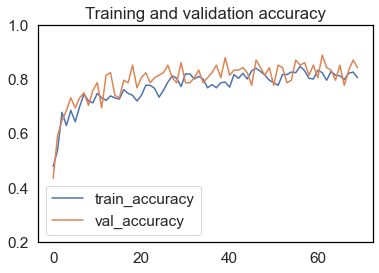

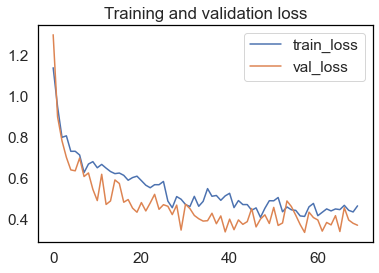

14/14 [==============================] - 2s 135ms/step - loss: 0.4129 - accuracy: 0.8796

batch size:  8
epochs:  80
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/80
54/54 [==============================] - 15s 213ms/step - loss: 1.0001 - accuracy: 0.5394 - val_loss: 1.2057 - val_accuracy: 0.4074

Epoch 00001: val_accuracy improved from -inf to 0.40741, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_1.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/80
54/54 [==============================] - 10s 179ms/step - loss: 0.7915 - accuracy: 0.6389 - val_loss: 0.9314 - val_accuracy: 0.5370

Epoch 00002: val_accuracy improved from 0.40741 to 0.53704, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_1.h5
Epoch 3/80
54/54 [==============================] - 10s 179ms/step - loss: 0.7620 - accuracy: 0.6597 - val_loss: 0.8181 - val_accuracy: 0.6574

Epoch 00003: val_accuracy improved from 0.53704 to 0.65741, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_1.h5
Epoch 4/80
54/54 [==============================] - 10s 178ms/step - loss: 0.7491 - accuracy: 0.6759 - val_loss: 0.7631 - val_accuracy: 0.6852

Epoch 00004: val_accuracy improved from 0.65741 to 0.68519, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_1.h5
Epoch 5/80
54/54 [==============================] - 9s 160ms/step - loss: 0.7125 - accuracy: 0.6921 - val_loss: 0.7376 - val_accuracy: 0.7130

Epoch 00005: val_accuracy improved 

54/54 [==============================] - 10s 176ms/step - loss: 0.4510 - accuracy: 0.8333 - val_loss: 0.4198 - val_accuracy: 0.7963

Epoch 00040: val_accuracy did not improve from 0.86111
Epoch 41/80
54/54 [==============================] - 10s 178ms/step - loss: 0.4769 - accuracy: 0.8218 - val_loss: 0.5609 - val_accuracy: 0.7963

Epoch 00041: val_accuracy did not improve from 0.86111
Epoch 42/80
54/54 [==============================] - 9s 172ms/step - loss: 0.4959 - accuracy: 0.8032 - val_loss: 0.4278 - val_accuracy: 0.8056

Epoch 00042: val_accuracy did not improve from 0.86111
Epoch 43/80
54/54 [==============================] - 10s 176ms/step - loss: 0.4977 - accuracy: 0.7894 - val_loss: 0.4632 - val_accuracy: 0.8056

Epoch 00043: val_accuracy did not improve from 0.86111
Epoch 44/80
54/54 [==============================] - 10s 177ms/step - loss: 0.4738 - accuracy: 0.8056 - val_loss: 0.4903 - val_accuracy: 0.7963

Epoch 00044: val_accuracy did not improve from 0.86111
Epoch 45/80
5


Epoch 00080: val_accuracy did not improve from 0.90741


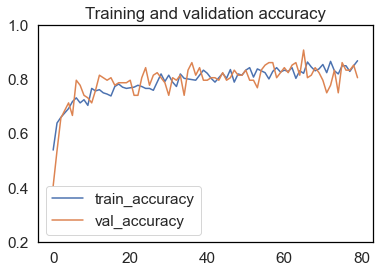

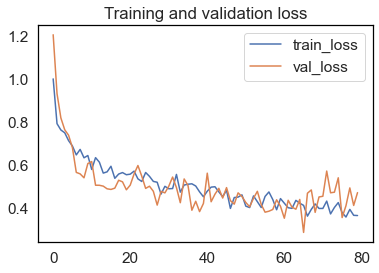

14/14 [==============================] - 2s 110ms/step - loss: 0.3646 - accuracy: 0.8796

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/80
54/54 [==============================] - 13s 195ms/step - loss: 1.1449 - accuracy: 0.4931 - val_loss: 1.1183 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_2.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/80
54/54 [==============================] - 8s 153ms/step - loss: 0.8465 - accuracy: 0.6481 - val_loss: 1.0484 - val_accuracy: 0.4907

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/80
54/54 [==============================] - 10s 176ms/step - loss: 0.7425 - accuracy: 0.6644 - val_loss: 0.8520 - val_accuracy: 0.5463

Epoch 00003: val_accuracy improved from 0.50000 to 0.54630, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_2.h5
Epoch 4/80
54/54 [==============================] - 10s 179ms/step - loss: 0.7092 - accuracy: 0.6852 - val_loss: 0.8297 - val_accuracy: 0.5741

Epoch 00004: val_accuracy improved from 0.54630 to 0.57407, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_2.h5
Epoch 5/80
54/54 [==============================] - 10s 179ms/step - loss: 0.6263 - accuracy: 0.7153 - val_loss: 0.7018 - val_accuracy: 0.6944

Epoch 00005: val_accuracy improved from 0.57407 to 0.69444, saving model to C:/Users/user/Desktop/Model/saved_

54/54 [==============================] - 10s 176ms/step - loss: 0.4047 - accuracy: 0.8519 - val_loss: 0.5755 - val_accuracy: 0.7778

Epoch 00040: val_accuracy did not improve from 0.81481
Epoch 41/80
54/54 [==============================] - 9s 172ms/step - loss: 0.4489 - accuracy: 0.8333 - val_loss: 0.5659 - val_accuracy: 0.7685

Epoch 00041: val_accuracy did not improve from 0.81481
Epoch 42/80
54/54 [==============================] - 10s 179ms/step - loss: 0.4544 - accuracy: 0.8148 - val_loss: 0.4874 - val_accuracy: 0.8241

Epoch 00042: val_accuracy improved from 0.81481 to 0.82407, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_2.h5
Epoch 43/80
54/54 [==============================] - 10s 181ms/step - loss: 0.4919 - accuracy: 0.7963 - val_loss: 0.5000 - val_accuracy: 0.7963

Epoch 00043: val_accuracy did not improve from 0.82407
Epoch 44/80
54/54 [==============================] - 10s 188ms/step - loss: 0.4203 - accuracy: 0.8171 - val_loss: 0.4669 - val_accuracy: 0

54/54 [==============================] - 14s 264ms/step - loss: 0.3765 - accuracy: 0.8565 - val_loss: 0.4450 - val_accuracy: 0.7870

Epoch 00080: val_accuracy did not improve from 0.86111


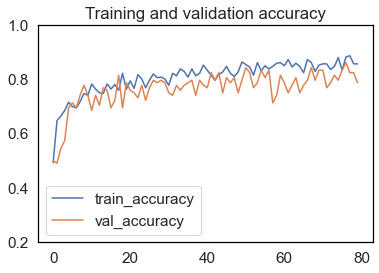

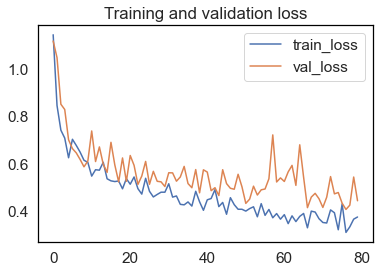

14/14 [==============================] - 3s 174ms/step - loss: 0.4949 - accuracy: 0.7963

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/80
54/54 [==============================] - 21s 314ms/step - loss: 1.0832 - accuracy: 0.5208 - val_loss: 0.8799 - val_accuracy: 0.6759

Epoch 00001: val_accuracy improved from -inf to 0.67593, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_3.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/80
54/54 [==============================] - 12s 224ms/step - loss: 0.9286 - accuracy: 0.5926 - val_loss: 0.7758 - val_accuracy: 0.7593

Epoch 00002: val_accuracy improved from 0.67593 to 0.75926, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_3.h5
Epoch 3/80
54/54 [==============================] - 12s 215ms/step - loss: 0.8160 - accuracy: 0.6227 - val_loss: 0.7224 - val_accuracy: 0.7037

Epoch 00003: val_accuracy did not improve from 0.75926
Epoch 4/80
54/54 [==============================] - 12s 222ms/step - loss: 0.7239 - accuracy: 0.6782 - val_loss: 0.6359 - val_accuracy: 0.6667

Epoch 00004: val_accuracy did not improve from 0.75926
Epoch 5/80
54/54 [==============================] - 10s 187ms/step - loss: 0.7151 - accuracy: 0.6898 - val_loss: 0.6568 - val_accuracy: 0.7222

Epoch 00005: val_accuracy did not improve from 0.75926
Epoch 6/80
54/54 [==============================] - 11s 196ms/step - loss: 0.6740 - accuracy: 0.6921 - val_loss: 0.6108 - val_acc

54/54 [==============================] - 15s 281ms/step - loss: 0.4808 - accuracy: 0.7940 - val_loss: 0.5932 - val_accuracy: 0.7593

Epoch 00041: val_accuracy did not improve from 0.83333
Epoch 42/80
54/54 [==============================] - 12s 222ms/step - loss: 0.4369 - accuracy: 0.8449 - val_loss: 0.5263 - val_accuracy: 0.7870

Epoch 00042: val_accuracy did not improve from 0.83333
Epoch 43/80
54/54 [==============================] - 13s 235ms/step - loss: 0.4284 - accuracy: 0.8310 - val_loss: 0.6266 - val_accuracy: 0.7407

Epoch 00043: val_accuracy did not improve from 0.83333
Epoch 44/80
54/54 [==============================] - 10s 180ms/step - loss: 0.4655 - accuracy: 0.8102 - val_loss: 0.5982 - val_accuracy: 0.7407

Epoch 00044: val_accuracy did not improve from 0.83333
Epoch 45/80
54/54 [==============================] - 10s 187ms/step - loss: 0.4588 - accuracy: 0.8102 - val_loss: 0.4427 - val_accuracy: 0.8148

Epoch 00045: val_accuracy did not improve from 0.83333
Epoch 46/80


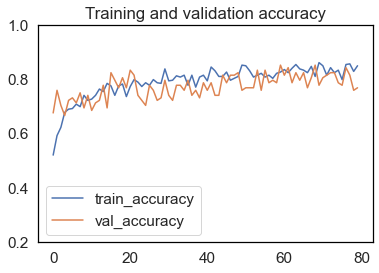

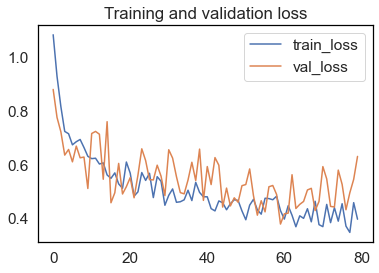

14/14 [==============================] - 2s 151ms/step - loss: 0.4274 - accuracy: 0.8148

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/80
54/54 [==============================] - 19s 298ms/step - loss: 1.0334 - accuracy: 0.5278 - val_loss: 0.9834 - val_accuracy: 0.4815

Epoch 00001: val_accuracy improved from -inf to 0.48148, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_4.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/80
54/54 [==============================] - 10s 191ms/step - loss: 0.8726 - accuracy: 0.6065 - val_loss: 0.8474 - val_accuracy: 0.6481

Epoch 00002: val_accuracy improved from 0.48148 to 0.64815, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_4.h5
Epoch 3/80
54/54 [==============================] - 12s 223ms/step - loss: 0.7913 - accuracy: 0.6551 - val_loss: 0.7436 - val_accuracy: 0.6944

Epoch 00003: val_accuracy improved from 0.64815 to 0.69444, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_4.h5
Epoch 4/80
54/54 [==============================] - 12s 219ms/step - loss: 0.7535 - accuracy: 0.6829 - val_loss: 0.6786 - val_accuracy: 0.7500

Epoch 00004: val_accuracy improved from 0.69444 to 0.75000, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_4.h5
Epoch 5/80
54/54 [==============================] - 11s 204ms/step - loss: 0.7571 - accuracy: 0.6991 - val_loss: 0.7056 - val_accuracy: 0.6481

Epoch 00005: val_accuracy did not 

54/54 [==============================] - 12s 215ms/step - loss: 0.4816 - accuracy: 0.7986 - val_loss: 0.4548 - val_accuracy: 0.8148

Epoch 00040: val_accuracy did not improve from 0.87037
Epoch 41/80
54/54 [==============================] - 14s 253ms/step - loss: 0.5135 - accuracy: 0.8009 - val_loss: 0.4108 - val_accuracy: 0.8426

Epoch 00041: val_accuracy did not improve from 0.87037
Epoch 42/80
54/54 [==============================] - 13s 245ms/step - loss: 0.4640 - accuracy: 0.8218 - val_loss: 0.4454 - val_accuracy: 0.7963

Epoch 00042: val_accuracy did not improve from 0.87037
Epoch 43/80
54/54 [==============================] - 13s 240ms/step - loss: 0.4807 - accuracy: 0.7824 - val_loss: 0.4835 - val_accuracy: 0.7778

Epoch 00043: val_accuracy did not improve from 0.87037
Epoch 44/80
54/54 [==============================] - 13s 231ms/step - loss: 0.4660 - accuracy: 0.8079 - val_loss: 0.3784 - val_accuracy: 0.8611

Epoch 00044: val_accuracy did not improve from 0.87037
Epoch 45/80



Epoch 00080: val_accuracy did not improve from 0.87963


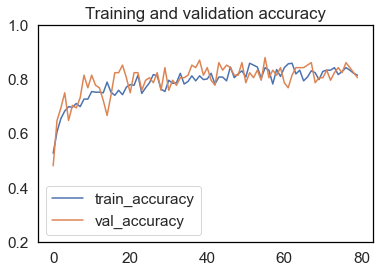

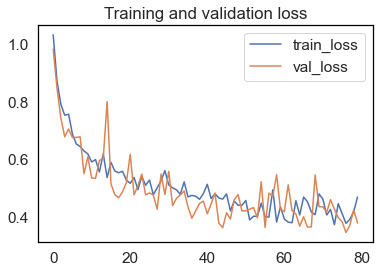

14/14 [==============================] - 2s 129ms/step - loss: 0.4286 - accuracy: 0.8241

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/80
54/54 [==============================] - 15s 216ms/step - loss: 1.0102 - accuracy: 0.5324 - val_loss: 0.8976 - val_accuracy: 0.5463

Epoch 00001: val_accuracy improved from -inf to 0.54630, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_5.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/80
54/54 [==============================] - 11s 208ms/step - loss: 0.8298 - accuracy: 0.6296 - val_loss: 0.8107 - val_accuracy: 0.6296

Epoch 00002: val_accuracy improved from 0.54630 to 0.62963, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_5.h5
Epoch 3/80
54/54 [==============================] - 11s 206ms/step - loss: 0.7875 - accuracy: 0.6250 - val_loss: 0.7207 - val_accuracy: 0.7037

Epoch 00003: val_accuracy improved from 0.62963 to 0.70370, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_5.h5
Epoch 4/80
54/54 [==============================] - 12s 215ms/step - loss: 0.7634 - accuracy: 0.6690 - val_loss: 0.6337 - val_accuracy: 0.7500

Epoch 00004: val_accuracy improved from 0.70370 to 0.75000, saving model to C:/Users/user/Desktop/Model/saved_models_2\model_5.h5
Epoch 5/80
54/54 [==============================] - 10s 179ms/step - loss: 0.6816 - accuracy: 0.7083 - val_loss: 0.6420 - val_accuracy: 0.6944

Epoch 00005: val_accuracy did not 

54/54 [==============================] - 12s 219ms/step - loss: 0.4923 - accuracy: 0.7986 - val_loss: 0.3898 - val_accuracy: 0.8426

Epoch 00040: val_accuracy did not improve from 0.89815
Epoch 41/80
54/54 [==============================] - 13s 243ms/step - loss: 0.4743 - accuracy: 0.8032 - val_loss: 0.3772 - val_accuracy: 0.8333

Epoch 00041: val_accuracy did not improve from 0.89815
Epoch 42/80
54/54 [==============================] - 13s 245ms/step - loss: 0.5126 - accuracy: 0.7894 - val_loss: 0.3719 - val_accuracy: 0.8148

Epoch 00042: val_accuracy did not improve from 0.89815
Epoch 43/80
54/54 [==============================] - 12s 224ms/step - loss: 0.4334 - accuracy: 0.8403 - val_loss: 0.3564 - val_accuracy: 0.8148

Epoch 00043: val_accuracy did not improve from 0.89815
Epoch 44/80
54/54 [==============================] - 12s 226ms/step - loss: 0.4239 - accuracy: 0.8380 - val_loss: 0.3954 - val_accuracy: 0.8056

Epoch 00044: val_accuracy did not improve from 0.89815
Epoch 45/80



Epoch 00080: val_accuracy did not improve from 0.90741


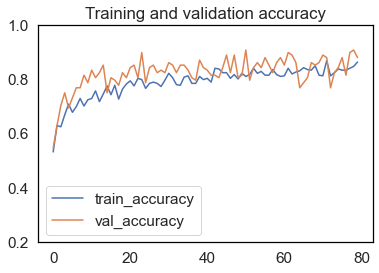

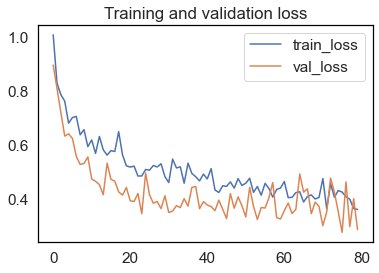

14/14 [==============================] - 3s 208ms/step - loss: 0.2996 - accuracy: 0.8981

batch size:  8
epochs:  90
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/90
54/54 [==============================] - 23s 299ms/step - loss: 1.0731 - accuracy: 0.5116 - val_loss: 0.9146 - val_accuracy: 0.5556

Epoch 00001: val_accuracy improved from -inf to 0.55556, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_1.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/90
54/54 [==============================] - 14s 263ms/step - loss: 0.8448 - accuracy: 0.6319 - val_loss: 0.8312 - val_accuracy: 0.6759

Epoch 00002: val_accuracy improved from 0.55556 to 0.67593, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_1.h5
Epoch 3/90
54/54 [==============================] - 10s 190ms/step - loss: 0.8467 - accuracy: 0.6134 - val_loss: 0.7661 - val_accuracy: 0.6759

Epoch 00003: val_accuracy did not improve from 0.67593
Epoch 4/90
54/54 [==============================] - 13s 233ms/step - loss: 0.7424 - accuracy: 0.6481 - val_loss: 0.6921 - val_accuracy: 0.7407

Epoch 00004: val_accuracy improved from 0.67593 to 0.74074, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_1.h5
Epoch 5/90
54/54 [==============================] - 12s 229ms/step - loss: 0.7206 - accuracy: 0.6644 - val_loss: 0.7128 - val_accuracy: 0.6852

Epoch 00005: val_accuracy did not improve from 0.74074
Epoch 6/90
54/54 [==============================] - 11

54/54 [==============================] - 13s 234ms/step - loss: 0.4242 - accuracy: 0.8171 - val_loss: 0.4081 - val_accuracy: 0.8148

Epoch 00040: val_accuracy did not improve from 0.84259
Epoch 41/90
54/54 [==============================] - 12s 225ms/step - loss: 0.4380 - accuracy: 0.8287 - val_loss: 0.4645 - val_accuracy: 0.7963

Epoch 00041: val_accuracy did not improve from 0.84259
Epoch 42/90
54/54 [==============================] - 10s 191ms/step - loss: 0.4360 - accuracy: 0.8287 - val_loss: 0.4347 - val_accuracy: 0.7778

Epoch 00042: val_accuracy did not improve from 0.84259
Epoch 43/90
54/54 [==============================] - 12s 230ms/step - loss: 0.4640 - accuracy: 0.8241 - val_loss: 0.5447 - val_accuracy: 0.7870

Epoch 00043: val_accuracy did not improve from 0.84259
Epoch 44/90
54/54 [==============================] - 11s 209ms/step - loss: 0.4385 - accuracy: 0.8380 - val_loss: 0.5739 - val_accuracy: 0.7315

Epoch 00044: val_accuracy did not improve from 0.84259
Epoch 45/90


54/54 [==============================] - 11s 194ms/step - loss: 0.4068 - accuracy: 0.8264 - val_loss: 0.4475 - val_accuracy: 0.8056

Epoch 00080: val_accuracy did not improve from 0.87963
Epoch 81/90
54/54 [==============================] - 14s 255ms/step - loss: 0.3831 - accuracy: 0.8426 - val_loss: 0.3455 - val_accuracy: 0.8796

Epoch 00081: val_accuracy did not improve from 0.87963
Epoch 82/90
54/54 [==============================] - 15s 278ms/step - loss: 0.3603 - accuracy: 0.8681 - val_loss: 0.4160 - val_accuracy: 0.8426

Epoch 00082: val_accuracy did not improve from 0.87963
Epoch 83/90
54/54 [==============================] - 12s 227ms/step - loss: 0.4027 - accuracy: 0.8495 - val_loss: 0.4559 - val_accuracy: 0.8056

Epoch 00083: val_accuracy did not improve from 0.87963
Epoch 84/90
54/54 [==============================] - 14s 248ms/step - loss: 0.4045 - accuracy: 0.8310 - val_loss: 0.3573 - val_accuracy: 0.8519

Epoch 00084: val_accuracy did not improve from 0.87963
Epoch 85/90


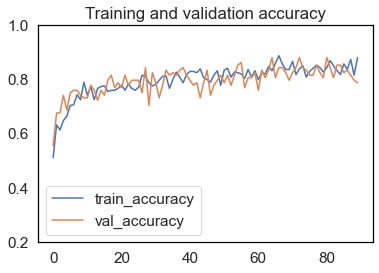

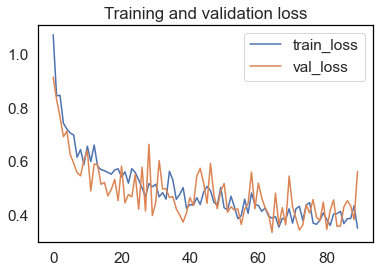

14/14 [==============================] - 2s 142ms/step - loss: 0.4673 - accuracy: 0.7963

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/90
54/54 [==============================] - 19s 268ms/step - loss: 1.0050 - accuracy: 0.5324 - val_loss: 0.9752 - val_accuracy: 0.5556

Epoch 00001: val_accuracy improved from -inf to 0.55556, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_2.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/90
54/54 [==============================] - 12s 216ms/step - loss: 0.9144 - accuracy: 0.6042 - val_loss: 0.8648 - val_accuracy: 0.5833

Epoch 00002: val_accuracy improved from 0.55556 to 0.58333, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_2.h5
Epoch 3/90
54/54 [==============================] - 11s 199ms/step - loss: 0.7665 - accuracy: 0.6551 - val_loss: 0.8003 - val_accuracy: 0.5926

Epoch 00003: val_accuracy improved from 0.58333 to 0.59259, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_2.h5
Epoch 4/90
54/54 [==============================] - 14s 252ms/step - loss: 0.7231 - accuracy: 0.6829 - val_loss: 0.7930 - val_accuracy: 0.6574

Epoch 00004: val_accuracy improved from 0.59259 to 0.65741, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_2.h5
Epoch 5/90
54/54 [==============================] - 12s 217ms/step - loss: 0.7150 - accuracy: 0.6875 - val_loss: 0.8343 - val_accuracy: 0.5926

Epoch 00005: val_accuracy did not 

54/54 [==============================] - 14s 264ms/step - loss: 0.4748 - accuracy: 0.7801 - val_loss: 0.6155 - val_accuracy: 0.7870

Epoch 00039: val_accuracy did not improve from 0.82407
Epoch 40/90
54/54 [==============================] - 12s 225ms/step - loss: 0.4479 - accuracy: 0.8125 - val_loss: 0.5768 - val_accuracy: 0.7593

Epoch 00040: val_accuracy did not improve from 0.82407
Epoch 41/90
54/54 [==============================] - 13s 237ms/step - loss: 0.4704 - accuracy: 0.8056 - val_loss: 0.5451 - val_accuracy: 0.7963

Epoch 00041: val_accuracy did not improve from 0.82407
Epoch 42/90
54/54 [==============================] - 10s 192ms/step - loss: 0.4381 - accuracy: 0.8218 - val_loss: 0.4851 - val_accuracy: 0.8148

Epoch 00042: val_accuracy did not improve from 0.82407
Epoch 43/90
54/54 [==============================] - 14s 254ms/step - loss: 0.4552 - accuracy: 0.8009 - val_loss: 0.4992 - val_accuracy: 0.8241

Epoch 00043: val_accuracy did not improve from 0.82407
Epoch 44/90



Epoch 00079: val_accuracy did not improve from 0.84259
Epoch 80/90
54/54 [==============================] - 11s 198ms/step - loss: 0.3370 - accuracy: 0.8727 - val_loss: 0.4100 - val_accuracy: 0.8148

Epoch 00080: val_accuracy did not improve from 0.84259
Epoch 81/90
54/54 [==============================] - 14s 254ms/step - loss: 0.3631 - accuracy: 0.8449 - val_loss: 0.4538 - val_accuracy: 0.8148

Epoch 00081: val_accuracy did not improve from 0.84259
Epoch 82/90
54/54 [==============================] - 12s 229ms/step - loss: 0.3191 - accuracy: 0.8704 - val_loss: 0.4856 - val_accuracy: 0.7870

Epoch 00082: val_accuracy did not improve from 0.84259
Epoch 83/90
54/54 [==============================] - 17s 310ms/step - loss: 0.3786 - accuracy: 0.8380 - val_loss: 0.4816 - val_accuracy: 0.8426

Epoch 00083: val_accuracy did not improve from 0.84259
Epoch 84/90
54/54 [==============================] - 12s 220ms/step - loss: 0.3391 - accuracy: 0.8750 - val_loss: 0.4206 - val_accuracy: 0.8333


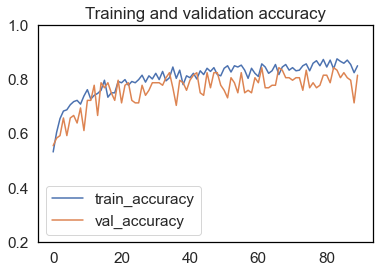

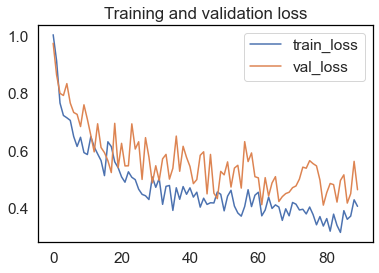

14/14 [==============================] - 3s 204ms/step - loss: 0.4375 - accuracy: 0.8241

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/90
54/54 [==============================] - 21s 294ms/step - loss: 1.1321 - accuracy: 0.4560 - val_loss: 0.9008 - val_accuracy: 0.6204

Epoch 00001: val_accuracy improved from -inf to 0.62037, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_3.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/90
54/54 [==============================] - 13s 239ms/step - loss: 0.8759 - accuracy: 0.6065 - val_loss: 0.8319 - val_accuracy: 0.6574

Epoch 00002: val_accuracy improved from 0.62037 to 0.65741, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_3.h5
Epoch 3/90
54/54 [==============================] - 13s 233ms/step - loss: 0.7644 - accuracy: 0.6690 - val_loss: 0.7804 - val_accuracy: 0.6852

Epoch 00003: val_accuracy improved from 0.65741 to 0.68519, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_3.h5
Epoch 4/90
54/54 [==============================] - 16s 286ms/step - loss: 0.7535 - accuracy: 0.6505 - val_loss: 0.7339 - val_accuracy: 0.6667

Epoch 00004: val_accuracy did not improve from 0.68519
Epoch 5/90
54/54 [==============================] - 11s 197ms/step - loss: 0.7176 - accuracy: 0.6759 - val_loss: 0.7084 - val_accuracy: 0.6852

Epoch 00005: val_accuracy did not improve from 0.68519
Epoch 6/90
54/54 [==============================] - 12

54/54 [==============================] - 11s 194ms/step - loss: 0.4283 - accuracy: 0.8264 - val_loss: 0.5080 - val_accuracy: 0.7778

Epoch 00041: val_accuracy did not improve from 0.83333
Epoch 42/90
54/54 [==============================] - 10s 180ms/step - loss: 0.4395 - accuracy: 0.8218 - val_loss: 0.4972 - val_accuracy: 0.7778

Epoch 00042: val_accuracy did not improve from 0.83333
Epoch 43/90
54/54 [==============================] - 12s 219ms/step - loss: 0.4376 - accuracy: 0.8449 - val_loss: 0.4651 - val_accuracy: 0.8056

Epoch 00043: val_accuracy did not improve from 0.83333
Epoch 44/90
54/54 [==============================] - 13s 233ms/step - loss: 0.4441 - accuracy: 0.8194 - val_loss: 0.4840 - val_accuracy: 0.8148

Epoch 00044: val_accuracy did not improve from 0.83333
Epoch 45/90
54/54 [==============================] - 12s 226ms/step - loss: 0.4351 - accuracy: 0.8333 - val_loss: 0.4090 - val_accuracy: 0.8241

Epoch 00045: val_accuracy did not improve from 0.83333
Epoch 46/90


54/54 [==============================] - 11s 211ms/step - loss: 0.3981 - accuracy: 0.8403 - val_loss: 0.4631 - val_accuracy: 0.7778

Epoch 00081: val_accuracy did not improve from 0.86111
Epoch 82/90
54/54 [==============================] - 12s 218ms/step - loss: 0.4054 - accuracy: 0.8519 - val_loss: 0.4993 - val_accuracy: 0.7963

Epoch 00082: val_accuracy did not improve from 0.86111
Epoch 83/90
54/54 [==============================] - 11s 204ms/step - loss: 0.3872 - accuracy: 0.8426 - val_loss: 0.4923 - val_accuracy: 0.8241

Epoch 00083: val_accuracy did not improve from 0.86111
Epoch 84/90
54/54 [==============================] - 12s 226ms/step - loss: 0.3649 - accuracy: 0.8542 - val_loss: 0.4361 - val_accuracy: 0.8333

Epoch 00084: val_accuracy did not improve from 0.86111
Epoch 85/90
54/54 [==============================] - 12s 220ms/step - loss: 0.3856 - accuracy: 0.8194 - val_loss: 0.3465 - val_accuracy: 0.8611

Epoch 00085: val_accuracy did not improve from 0.86111
Epoch 86/90


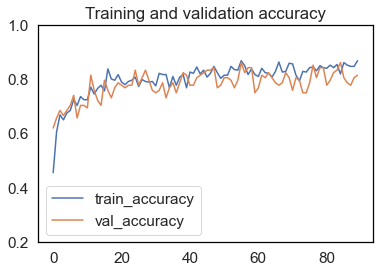

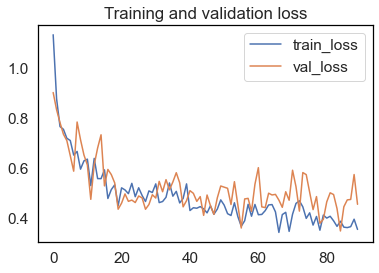

14/14 [==============================] - 2s 141ms/step - loss: 0.4759 - accuracy: 0.8148

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/90
54/54 [==============================] - 15s 210ms/step - loss: 1.1185 - accuracy: 0.5162 - val_loss: 1.0314 - val_accuracy: 0.4537

Epoch 00001: val_accuracy improved from -inf to 0.45370, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_4.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/90
54/54 [==============================] - 10s 191ms/step - loss: 0.8434 - accuracy: 0.6019 - val_loss: 0.8519 - val_accuracy: 0.6759

Epoch 00002: val_accuracy improved from 0.45370 to 0.67593, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_4.h5
Epoch 3/90
54/54 [==============================] - 12s 228ms/step - loss: 0.8397 - accuracy: 0.6551 - val_loss: 0.7770 - val_accuracy: 0.6481

Epoch 00003: val_accuracy did not improve from 0.67593
Epoch 4/90
54/54 [==============================] - 11s 207ms/step - loss: 0.7632 - accuracy: 0.6597 - val_loss: 0.6840 - val_accuracy: 0.7222

Epoch 00004: val_accuracy improved from 0.67593 to 0.72222, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_4.h5
Epoch 5/90
54/54 [==============================] - 11s 201ms/step - loss: 0.7338 - accuracy: 0.6875 - val_loss: 0.5821 - val_accuracy: 0.7963

Epoch 00005: val_accuracy improved from 0.72222 to 0.79630, saving model to C:/Users/user/Desktop/Model/saved

Epoch 41/90
54/54 [==============================] - 10s 181ms/step - loss: 0.4496 - accuracy: 0.8125 - val_loss: 0.4802 - val_accuracy: 0.8333

Epoch 00041: val_accuracy did not improve from 0.87963
Epoch 42/90
54/54 [==============================] - 11s 208ms/step - loss: 0.4173 - accuracy: 0.8194 - val_loss: 0.4098 - val_accuracy: 0.8426

Epoch 00042: val_accuracy did not improve from 0.87963
Epoch 43/90
54/54 [==============================] - 10s 191ms/step - loss: 0.4493 - accuracy: 0.8264 - val_loss: 0.4323 - val_accuracy: 0.8426

Epoch 00043: val_accuracy did not improve from 0.87963
Epoch 44/90
54/54 [==============================] - 11s 205ms/step - loss: 0.5031 - accuracy: 0.8125 - val_loss: 0.4970 - val_accuracy: 0.8056

Epoch 00044: val_accuracy did not improve from 0.87963
Epoch 45/90
54/54 [==============================] - 11s 199ms/step - loss: 0.4702 - accuracy: 0.8032 - val_loss: 0.3712 - val_accuracy: 0.8333

Epoch 00045: val_accuracy did not improve from 0.87963



Epoch 00081: val_accuracy did not improve from 0.88889
Epoch 82/90
54/54 [==============================] - 13s 232ms/step - loss: 0.3854 - accuracy: 0.8333 - val_loss: 0.3528 - val_accuracy: 0.8426

Epoch 00082: val_accuracy did not improve from 0.88889
Epoch 83/90
54/54 [==============================] - 11s 201ms/step - loss: 0.3844 - accuracy: 0.8519 - val_loss: 0.3993 - val_accuracy: 0.8333

Epoch 00083: val_accuracy did not improve from 0.88889
Epoch 84/90
54/54 [==============================] - 11s 197ms/step - loss: 0.3886 - accuracy: 0.8449 - val_loss: 0.5123 - val_accuracy: 0.7685

Epoch 00084: val_accuracy did not improve from 0.88889
Epoch 85/90
54/54 [==============================] - 12s 216ms/step - loss: 0.3599 - accuracy: 0.8403 - val_loss: 0.4143 - val_accuracy: 0.8241

Epoch 00085: val_accuracy did not improve from 0.88889
Epoch 86/90
54/54 [==============================] - 10s 181ms/step - loss: 0.3989 - accuracy: 0.8542 - val_loss: 0.4052 - val_accuracy: 0.8889


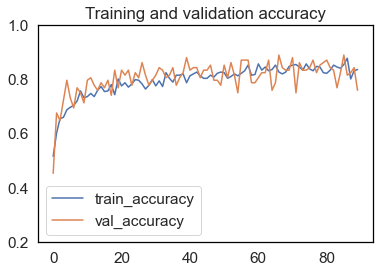

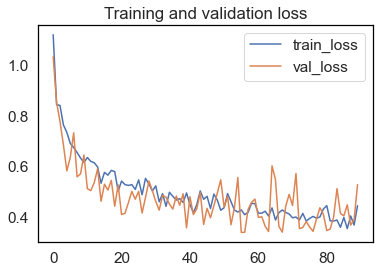

14/14 [==============================] - 2s 166ms/step - loss: 0.3662 - accuracy: 0.8796

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Epoch 1/90
54/54 [==============================] - 17s 239ms/step - loss: 1.0602 - accuracy: 0.5185 - val_loss: 1.0009 - val_accuracy: 0.4722

Epoch 00001: val_accuracy improved from -inf to 0.47222, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_5.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/90
54/54 [==============================] - 11s 195ms/step - loss: 0.8185 - accuracy: 0.6458 - val_loss: 0.9250 - val_accuracy: 0.5370

Epoch 00002: val_accuracy improved from 0.47222 to 0.53704, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_5.h5
Epoch 3/90
54/54 [==============================] - 12s 213ms/step - loss: 0.7992 - accuracy: 0.6343 - val_loss: 0.8305 - val_accuracy: 0.6296

Epoch 00003: val_accuracy improved from 0.53704 to 0.62963, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_5.h5
Epoch 4/90
54/54 [==============================] - 10s 191ms/step - loss: 0.7326 - accuracy: 0.6852 - val_loss: 0.6903 - val_accuracy: 0.7222

Epoch 00004: val_accuracy improved from 0.62963 to 0.72222, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_5.h5
Epoch 5/90
54/54 [==============================] - 15s 272ms/step - loss: 0.7006 - accuracy: 0.6944 - val_loss: 0.7430 - val_accuracy: 0.6574

Epoch 00005: val_accuracy did not 

54/54 [==============================] - 14s 258ms/step - loss: 0.4559 - accuracy: 0.8218 - val_loss: 0.3247 - val_accuracy: 0.8889

Epoch 00040: val_accuracy improved from 0.87963 to 0.88889, saving model to C:/Users/user/Desktop/Model/saved_models_3\model_5.h5
Epoch 41/90
54/54 [==============================] - 13s 242ms/step - loss: 0.4416 - accuracy: 0.8218 - val_loss: 0.3678 - val_accuracy: 0.8426

Epoch 00041: val_accuracy did not improve from 0.88889
Epoch 42/90
54/54 [==============================] - 11s 203ms/step - loss: 0.5026 - accuracy: 0.8102 - val_loss: 0.4539 - val_accuracy: 0.8241

Epoch 00042: val_accuracy did not improve from 0.88889
Epoch 43/90
54/54 [==============================] - 11s 204ms/step - loss: 0.4698 - accuracy: 0.8148 - val_loss: 0.4349 - val_accuracy: 0.8519

Epoch 00043: val_accuracy did not improve from 0.88889
Epoch 44/90
54/54 [==============================] - 11s 194ms/step - loss: 0.4898 - accuracy: 0.8218 - val_loss: 0.3832 - val_accuracy: 

54/54 [==============================] - 10s 183ms/step - loss: 0.3763 - accuracy: 0.8472 - val_loss: 0.3461 - val_accuracy: 0.8333

Epoch 00080: val_accuracy did not improve from 0.90741
Epoch 81/90
54/54 [==============================] - 12s 228ms/step - loss: 0.3796 - accuracy: 0.8495 - val_loss: 0.3879 - val_accuracy: 0.8519

Epoch 00081: val_accuracy did not improve from 0.90741
Epoch 82/90
54/54 [==============================] - 12s 221ms/step - loss: 0.3733 - accuracy: 0.8380 - val_loss: 0.3057 - val_accuracy: 0.8889

Epoch 00082: val_accuracy did not improve from 0.90741
Epoch 83/90
54/54 [==============================] - 11s 205ms/step - loss: 0.3411 - accuracy: 0.8634 - val_loss: 0.2858 - val_accuracy: 0.8796

Epoch 00083: val_accuracy did not improve from 0.90741
Epoch 84/90
54/54 [==============================] - 10s 193ms/step - loss: 0.3686 - accuracy: 0.8565 - val_loss: 0.3971 - val_accuracy: 0.8519

Epoch 00084: val_accuracy did not improve from 0.90741
Epoch 85/90


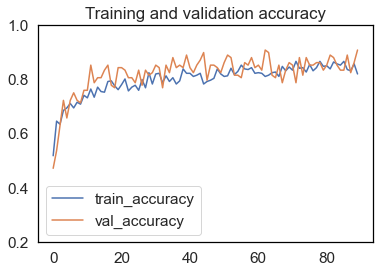

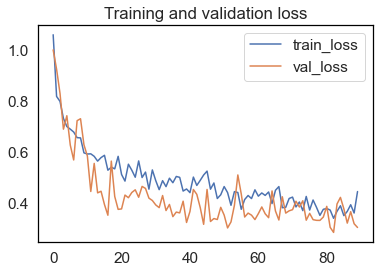

14/14 [==============================] - 2s 142ms/step - loss: 0.3615 - accuracy: 0.8333


In [32]:
#for test set accuracy
#---------------------------------------------------------------------------
test_set = directory + "/ToBeUsed/test_set"

testX = []

for img_path in X_test['filename']:
    img = im.load_img(img_path, target_size=(224,224))
    x = im.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = x.reshape(224,224,3)
    testX.append(x)

testX = np.array(testX)
#---------------------------------------------------------------------------

#make the labels to integer to get the model metrics
yt = pd.to_numeric(y_test['label'])

for x in range(len(batch_size_arr)):
    
    #for batch size values
    if len(param_arr) == 0:
        param_arr.append([])
    
    for y in range(len(num_epochs_arr)):

        #for epoch values
        if len(param_arr) == 1:
            param_arr.append([])
        
        for z in range(len(lr_arr)):
            
            #for learning rate values
            if len(param_arr) == 2:
                param_arr.append([])
                
            print('')
            print("batch size: ", batch_size_arr[x])
            print("epochs: ", num_epochs_arr[y])
            print("learning rate: ", lr_arr[z])
            print('')
            
            #append the values per combo
            param_arr[0].append(batch_size_arr[x])
            param_arr[1].append(num_epochs_arr[y])
            param_arr[2].append(lr_arr[z])
            
            VALIDATION_ACCURACY = []
            VALIDATION_LOSS = []
            
            TRAIN_ACCURACY = []
            TRAIN_LOSS = []
            
            TEST_ACCURACY = []
            TEST_LOSS = []
            
            #change save_dir value per combination
            save_dir = savemodel()
            fold_var = 1
            
            for train_index, val_index in skf.split(np.zeros(len(df2)),Y):

                training_data = df2.iloc[train_index]
                validation_data = df2.iloc[val_index]
                
                print('')
                print("Fold number " + str(fold_var))
                
                train_data_generator = imgdatagen.flow_from_dataframe(training_data, directory = image_dir,
                                           x_col = "filename", y_col = "label",
                                          class_mode = "categorical", target_size = (224,224), batch_size = batch_size_arr[x],
                                            shuffle = True)
                valid_data_generator  = imgdatagen.flow_from_dataframe(validation_data, directory = image_dir,
                                        x_col = "filename", y_col = "label",
                                        class_mode = "categorical", target_size = (224,224), batch_size = batch_size_arr[x],
                                            shuffle = True)
                
                full_model = model()
                # Compile the model
                full_model.compile(loss='categorical_crossentropy',
                              optimizer=keras.optimizers.Adamax(learning_rate=lr_arr[z]),
                              metrics=['accuracy']) #categorical_crossentropy cause it is more than 2 classes

                # Create callbacks
                checkpoint = tf.keras.callbacks.ModelCheckpoint((save_dir+"/"+ "model_" + str(fold_var) + ".h5"), 
                                        monitor='val_accuracy', verbose=1, 
                                        save_best_only=True, mode='max')
                callbacks_list = [checkpoint]
                # This saves the best model


                # Fit the model
                history = full_model.fit(train_data_generator,
                                         epochs=num_epochs_arr[y],
                                         callbacks=callbacks_list,
                                         validation_data=valid_data_generator,
                                         verbose=1)

                # Plot the history
                plot_history(history, yrange=(0.2,1))

                # Load the best model instance to evaluate the performance of the model
                full_model.load_weights(save_dir+"/model_"+str(fold_var)+".h5")

                results = full_model.evaluate(valid_data_generator)
                results = dict(zip(full_model.metrics_names,results))

                # Store Validation accuracy/loss
                VALIDATION_ACCURACY.append(results['accuracy'])
                VALIDATION_LOSS.append(results['loss'])
                
                # Store Train accuracy/loss
                TRAIN_ACCURACY.append(np.mean(history.history['accuracy']))
                TRAIN_LOSS.append(np.mean(history.history['loss']))
                
                # Predict test set to get the test accuracy/loss
                yhat_probs = full_model.predict(testX, verbose=0)
                yhat_classes = yhat_probs.argmax(axis=-1)
                
                # Test accuracy and loss score
                accuracy = accuracy_score(yt, yhat_classes)
                loss = log_loss(yt, yhat_probs)
                
                # Store Test accuracy and loss
                TEST_ACCURACY.append(accuracy)
                TEST_LOSS.append(loss)
                
                tf.keras.backend.clear_session()

                fold_var += 1
                
            val_acc_arr.append(VALIDATION_ACCURACY)
            val_loss_arr.append(VALIDATION_LOSS)
            
            train_acc_arr.append(TRAIN_ACCURACY)                            
            train_loss_arr.append(TRAIN_LOSS)
            
            test_acc_arr.append(TEST_ACCURACY)
            test_loss_arr.append(TEST_LOSS)

In [33]:
#append means of accuracy and loss sets per combo
for x in range(len(val_acc_arr)):
    val_acc_means.append(np.mean(val_acc_arr[x]))                                
    val_loss_means.append(np.mean(val_loss_arr[x]))
    
    train_acc_means.append(np.mean(train_acc_arr[x]))                              
    train_loss_means.append(np.mean(train_loss_arr[x]))                             

    test_acc_means.append(np.mean(test_acc_arr[x]))                               
    test_loss_means.append(np.mean(test_loss_arr[x]))                            

### Display Values Per Combination of Parameters

We will put the combination of parameters and the resulting means of accuracy and loss together in a dataframe in order to display it nicely.

In [34]:
df_hyperparam = pd.DataFrame(list(zip(param_arr[0],param_arr[1],param_arr[2],
                                      train_acc_means, train_loss_means,
                                      val_acc_means,val_loss_means,
                                      test_acc_means, test_loss_means))
                             ,columns=['batch size','number of epoch', 'learning rate', 
                                       'train accuracy', 'train loss',
                                       'val accuracy', 'val loss',
                                       'test accuracy', 'test loss'])

df_hyperparam = df_hyperparam.sort_values(by = 'test accuracy')
df_hyperparam

batch size  number of epoch  learning rate  train accuracy  train loss  \
1           8               80         0.0001        0.793374    0.499394   
0           8               70         0.0001        0.784405    0.520373   
2           8               90         0.0001        0.799270    0.486522   

   val accuracy  val loss  test accuracy  test loss  
1      0.842593  0.403017       0.823333   0.394589  
0      0.848148  0.410123       0.830000   0.395376  
2      0.829630  0.421681       0.836667   0.368995

## Kfold Evaluation Results

Below are the validation accuracy and validation loss per fold and their average of the best combination.

In [37]:
model_no = 2
n = 1

print("Validation Accuracy of All Folds:")
for x in val_acc_arr[model_no]:
    print("Fold "+ str(n) +" Accuracy:",x)
    n=n+1    
print("Mean Validation Accuracy: " + str(np.mean(val_acc_arr[model_no])))

print("")

print("Validation Loss of All Folds:")
n=1
for x in val_loss_arr[model_no]:
    print("Fold "+ str(n) +" Loss:",x)
    n=n+1    
print("Mean Validation Loss: " + str(np.mean(val_loss_arr[model_no])))

Validation Accuracy of All Folds:
Fold 1 Accuracy: 0.7962962985038757
Fold 2 Accuracy: 0.8240740895271301
Fold 3 Accuracy: 0.8148148059844971
Fold 4 Accuracy: 0.8796296119689941
Fold 5 Accuracy: 0.8333333134651184
Mean Validation Accuracy: 0.8296296238899231

Validation Loss of All Folds:
Fold 1 Loss: 0.46734750270843506
Fold 2 Loss: 0.43751436471939087
Fold 3 Loss: 0.47588154673576355
Fold 4 Loss: 0.36616989970207214
Fold 5 Loss: 0.3614926040172577
Mean Validation Loss: 0.42168118357658385


## Model Prediction and Evaluation

Load the images in the test set and predict what class it is in all models of the best combination. There are three values of confidence level. The one with the highest confidence level is the predicted class of the image. The order of classes is [0 1 2]. The results will be feed to the eval function defined below in order to get the metrics.

In [58]:
#make the labels to integer to get the model metrics
yt = pd.to_numeric(y_test['label'])

The content displayed are the metrics, roc auc of each class (balut/penoy,salted,table), and confusion matrix per fold, as well as the sum and mean of those confusion matrices and roc auc of each class for all folds.

In [59]:
#Metrics
def evaluate(yhat_probs, 
             yhat_classes, 
             total_acc,
             total_loss,
             total_precision, 
             total_recall, 
             total_f1_score, 
             matrix_sum,
             fold_num,
             fpr_total,
             tpr_total):

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(yt, yhat_classes)
    total_acc.append(accuracy)
    print('Accuracy: %f' % accuracy)
    # loss
    loss = log_loss(yt, yhat_probs)
    total_loss.append(loss)
    print('Loss: %f' % loss)
    # precision tp / (tp + fp)
    precision = precision_score(yt, yhat_classes, average="weighted")
    total_precision.append(precision)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(yt, yhat_classes, average="weighted")
    total_recall.append(recall)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(yt, yhat_classes, average="weighted")
    total_f1_score.append(f1)
    print('F1 score: %f' % f1)
    
    #ROC AUC
    #-------------------------------------------------------------------------------
    # Binarize the true label
    ytbin = label_binarize(yt, classes=[0, 1, 2])
    n_classes = ytbin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
      
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytbin[:, i], yhat_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
     
        if fold_num == 0:
            fpr_total.append([])

        fpr_total[i].append(fpr[i])
        
        if fold_num == 0:
            tpr_total.append([])

        tpr_total[i].append(tpr[i]) 

    # Compute micro-average ROC curve and ROC area
    fpr["macro"], tpr["macro"], _ = roc_curve(ytbin.ravel(), yhat_probs.ravel())
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"]  = 1.25
    
    #balut-penoy
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Balut-Penoy Fold ' + str(fold_num+1))
    plt.legend(loc="lower right")
    plt.show()

    #salted egg
    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Salted Egg Fold ' + str(fold_num+1))
    plt.legend(loc="lower right")
    plt.show()

    #table egg
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Table Egg Fold ' + str(fold_num+1))
    plt.legend(loc="lower right")
    plt.show()
    #-------------------------------------------------------------------------------
    
    #confusion matrix
    matrix = confusion_matrix(yt, yhat_classes)
    
    if len(total_acc) == 1:
        matrix_sum = matrix
    elif len(total_acc) > 1:
        matrix_sum = [[matrix_sum[i][j] + matrix[i][j]  
                       for j in range(len(matrix_sum[0]))] 
                      for i in range(len(matrix_sum))]
    
    df_cm = pd.DataFrame(matrix, range(matrix.shape[0]), range(matrix.shape[1]))
    df_cm = df_cm.rename(columns={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'}, 
                         index={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'})
    
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title('Confusion Matrix Fold ' + str(fold_num+1))
    plt.show()
    
    return total_acc, total_loss, total_precision, total_recall, total_f1_score, matrix_sum, fpr_total, tpr_total

fold 1 metrics:
Accuracy: 0.866667
Loss: 0.383467
Precision: 0.888034
Recall: 0.866667
F1 score: 0.866815


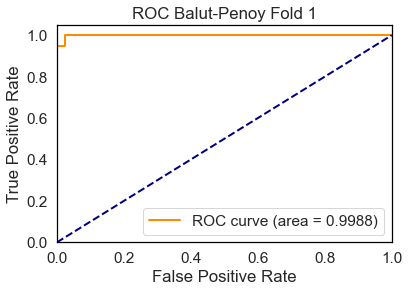

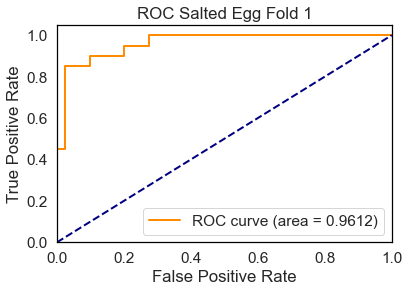

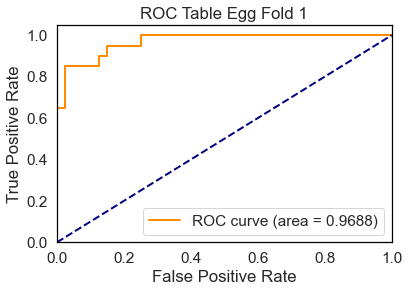

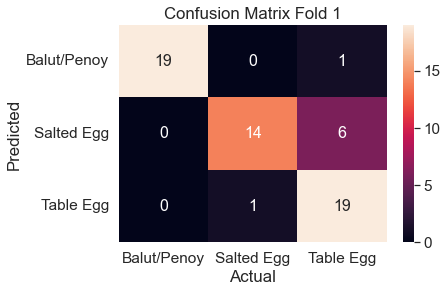


fold 2 metrics:
Accuracy: 0.816667
Loss: 0.361374
Precision: 0.861464
Recall: 0.816667
F1 score: 0.812707


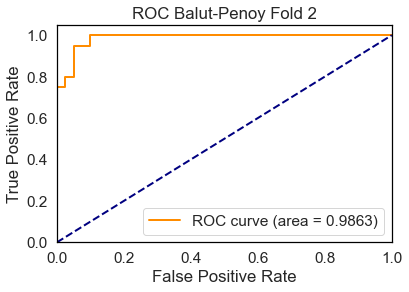

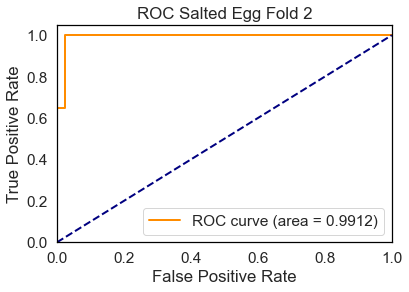

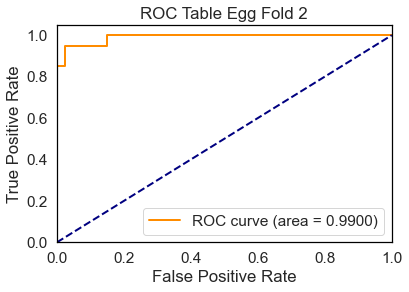

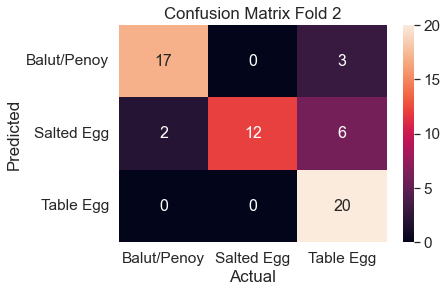


fold 3 metrics:
Accuracy: 0.783333
Loss: 0.411652
Precision: 0.791358
Recall: 0.783333
F1 score: 0.775417


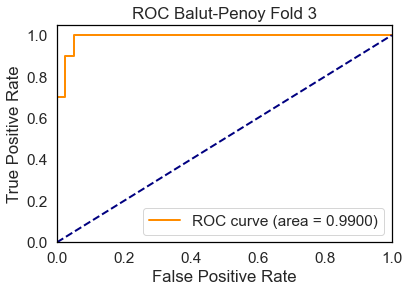

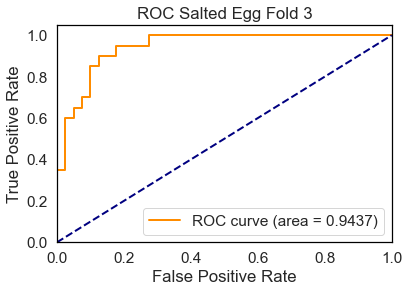

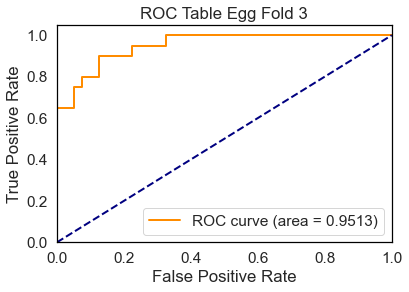

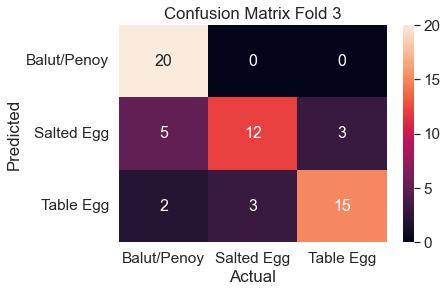


fold 4 metrics:
Accuracy: 0.816667
Loss: 0.385744
Precision: 0.825958
Recall: 0.816667
F1 score: 0.816254


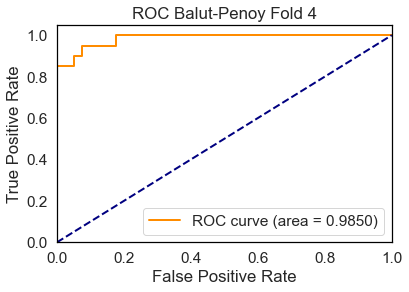

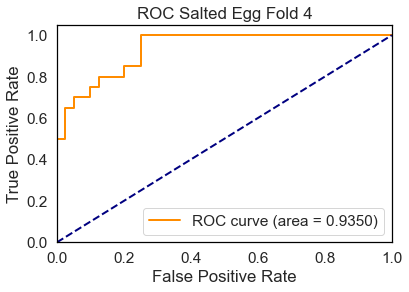

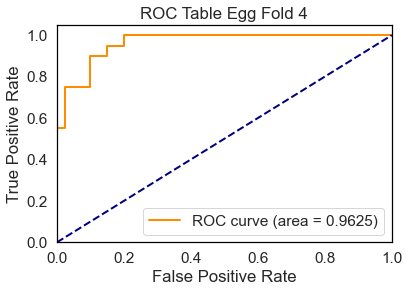

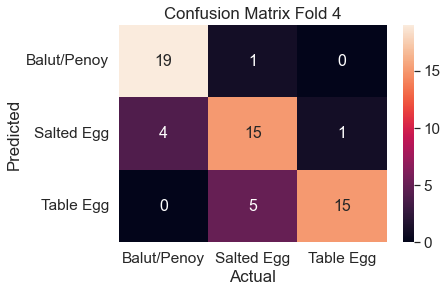


fold 5 metrics:
Accuracy: 0.900000
Loss: 0.302739
Precision: 0.911111
Recall: 0.900000
F1 score: 0.899327


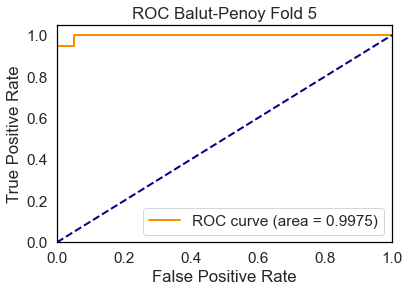

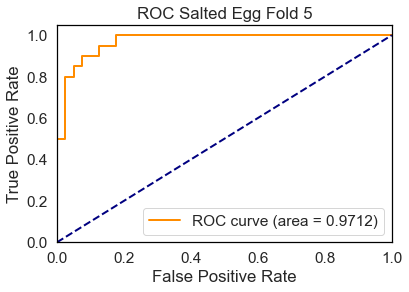

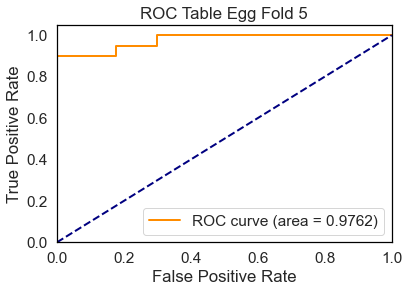

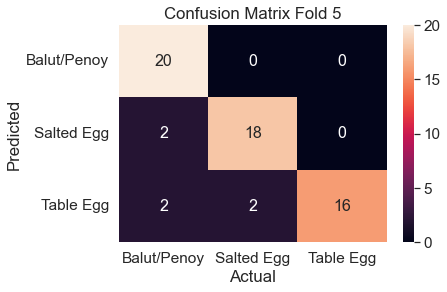

In [60]:
fold = 5

#modelname = "saved_models_"+str(model_no+1)
modelname = "saved_models_3"

#for fold number and average string
fold_ave = []

#for metrics values
total_acc = []
total_loss = []
total_precision = []
total_recall = []
total_f1_score = []

#for confusion matrix sum of folds
matrix_sum = np.array([])

#for roc auc of folds per class
fpr_bp = []
tpr_bp = []

fpr_se = []
tpr_se = []

fpr_te = []
tpr_te = []

fpr_total = []
tpr_total = []

#for validating misclassified images
yhat_classes_total = []

for fold_num in range(fold):
    
    full_model = model()
    
    #load the weights of bet model
    model_dir = gen_dir + "/"+modelname+"/model_"+str(fold_num+1)+".h5"
    full_model.load_weights(model_dir)

    test_set = directory + "/ToBeUsed/test_set"

    testX = []

    for img_path in X_test['filename']:
        img = im.load_img(img_path, target_size=(224,224))
        x = im.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x.reshape(224,224,3)
        testX.append(x)

    testX = np.array(testX)    

    # predict probabilities for test set, y_test
    yhat_probs = full_model.predict(testX, verbose=0)

    # predict crisp classes for test set
    yhat_classes = yhat_probs.argmax(axis=-1)
    
    yhat_classes_total.append(yhat_classes)
    
    print("fold "+str(fold_num+1) +" metrics:")
    total_acc, total_loss, total_precision, total_recall, total_f1_score, matrix_sum, fpr_total, tpr_total  = evaluate(yhat_probs,
                                                                                                           yhat_classes,
                                                                                                           total_acc,
                                                                                                           total_loss,
                                                                                                           total_precision,
                                                                                                           total_recall,
                                                                                                           total_f1_score,
                                                                                                           matrix_sum,
                                                                                                           fold_num,
                                                                                                           fpr_total,
                                                                                                           tpr_total)
    
    fold_ave.append(str(fold_num+1))
    
    print('')


In [61]:
#Metrics
#-------------------------------------------------------------------------------------------------------------
fold_ave.append("Ave:")
total_acc.append(np.mean(total_acc))
total_loss.append(np.mean(total_loss))
total_precision.append(np.mean(total_precision))
total_recall.append(np.mean(total_recall))
total_f1_score.append(np.mean(total_recall))
    
df_eval = pd.DataFrame(data = list(zip(fold_ave,
                                       total_acc,
                                       total_loss,
                                       total_precision,
                                       total_recall,
                                       total_f1_score)), columns=["Fold",
                                                                  "Accuracy",
                                                                  "Loss",
                                                                  "Precision",
                                                                  "Recall",
                                                                  "F1 Score"])

#set fold_ave as the index
df_eval.set_index("Fold",inplace=True)

df_eval
#-------------------------------------------------------------------------------------------------------------

Accuracy      Loss  Precision    Recall  F1 Score
Fold                                                   
1     0.866667  0.383467   0.888034  0.866667  0.866815
2     0.816667  0.361374   0.861464  0.816667  0.812707
3     0.783333  0.411652   0.791358  0.783333  0.775417
4     0.816667  0.385744   0.825958  0.816667  0.816254
5     0.900000  0.302739   0.911111  0.900000  0.899327
Ave:  0.836667  0.368995   0.855585  0.836667  0.836667

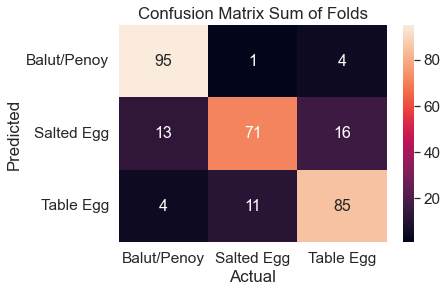

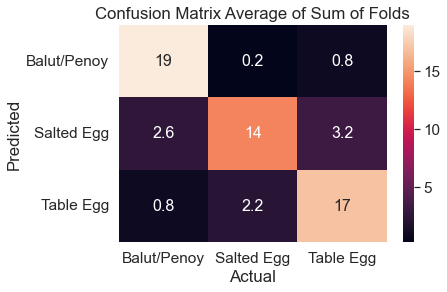

In [62]:
#Confusion Matrix
#-------------------------------------------------------------------------------------------------------------
#confusion matrix sum of folds
matrix_sum = np.array(matrix_sum)

df_cm = pd.DataFrame(matrix_sum, range(matrix_sum.shape[0]), range(matrix_sum.shape[1]))
df_cm = df_cm.rename(columns={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'}, 
                     index={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'})

# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix Sum of Folds")
plt.show()

#confusion matrix ave of sum of folds
matrix_ave = [[matrix_sum[i][j]/fold 
               for j in range(len(matrix_sum[0]))] 
              for i in range(len(matrix_sum))]

matrix_ave = np.array(matrix_ave)

df_cm = pd.DataFrame(matrix_ave, range(matrix_ave.shape[0]), range(matrix_ave.shape[1]))
df_cm = df_cm.rename(columns={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'}, 
                     index={0:'Balut/Penoy', 1:'Salted Egg', 2:'Table Egg'})

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix Average of Sum of Folds")
plt.show()
#-------------------------------------------------------------------------------------------------------------

C:\Users\user\AppData\Local\Temp/ipykernel_23320/224870489.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fpr_total = np.array(fpr_total)
C:\Users\user\AppData\Local\Temp/ipykernel_23320/224870489.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tpr_total = np.array(tpr_total)
C:\Users\user\AppData\Local\Temp/ipykernel_23320/224870489.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


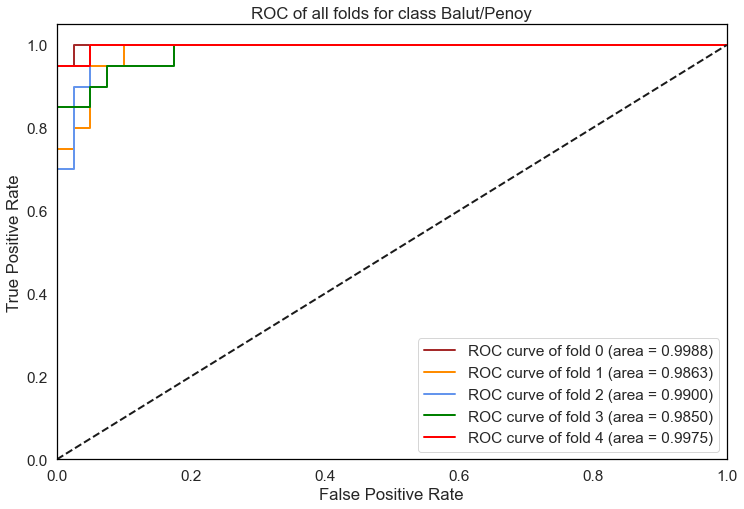

C:\Users\user\AppData\Local\Temp/ipykernel_23320/224870489.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


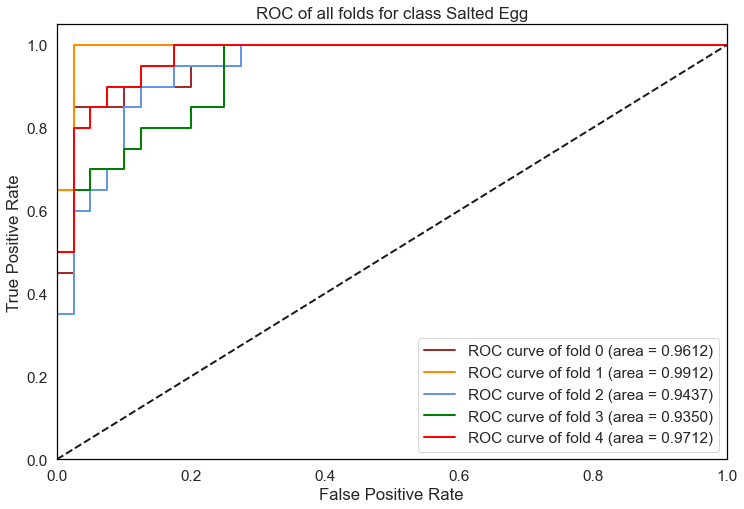

C:\Users\user\AppData\Local\Temp/ipykernel_23320/224870489.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


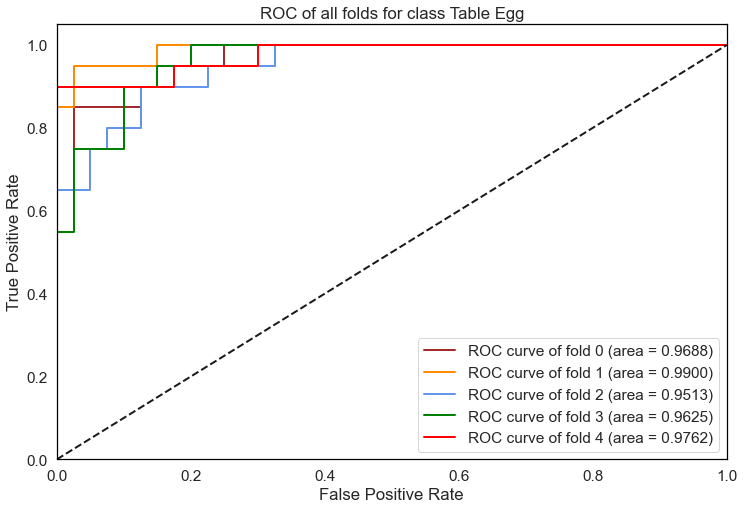

In [63]:
#ROC AUC
#-------------------------------------------------------------------------------------------------------------
fpr_total = np.array(fpr_total)
tpr_total = np.array(tpr_total)

#print("fpr_total")
#print(fpr_total)
#print("\ntpr_total")
#print(tpr_total)

classes = ["Balut/Penoy","Salted Egg","Table Egg"]

for x in range(len(fpr_total)):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(fold):
        fpr[i] = fpr_total[x][i]
        tpr[i] = tpr_total[x][i]
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(fold)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(fold):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= fold
   
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"]  = 1.25

    # Plot all ROC curves
    plt.figure(figsize=(12, 8))
    lw = 2
   
    colors = cycle(['brown', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(fold), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of fold {0} (area = {1:0.4f})'
                 ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of all folds for class ' + classes[x])
    plt.legend(loc="lower right")
    plt.show()
#-------------------------------------------------------------------------------------------------------------

## Validating Misclassified Images

We will check whether or not the predicted classes of the images match with the true classes that they have. We will display the correct and incorrect predictions.

In [64]:
for yhat_classes in yhat_classes_total:
    print(yhat_classes.shape, yt.shape)

(60,) (60,)
(60,) (60,)
(60,) (60,)
(60,) (60,)
(60,) (60,)


We will get the images from the directories stored under the filename column.

In [65]:
testX2 = []

for img_path in X_test['filename']:
    img = cv2.imread(img_path)
    testX2.append(img)

testX2 = np.array(testX2)

### Correct predictions

Fold 1
Found 52 correct labels
8


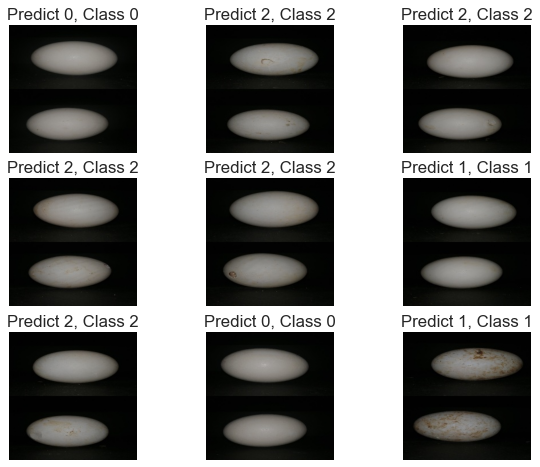

Fold 2
Found 49 correct labels
8


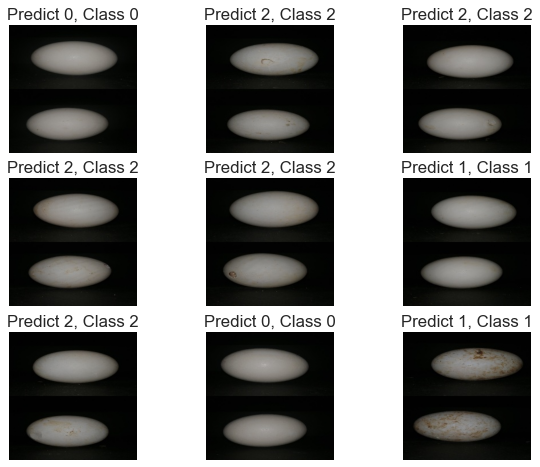

Fold 3
Found 47 correct labels
10


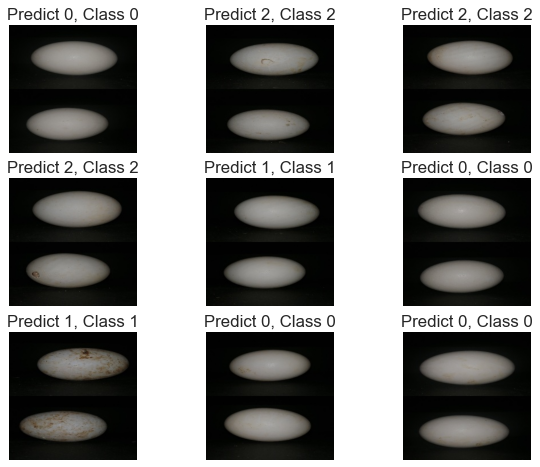

Fold 4
Found 49 correct labels
11


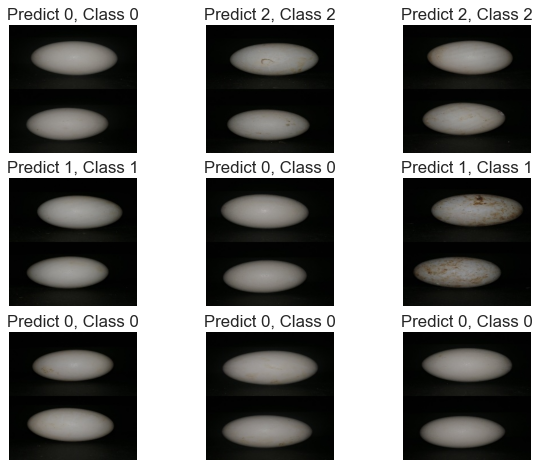

Fold 5
Found 54 correct labels
11


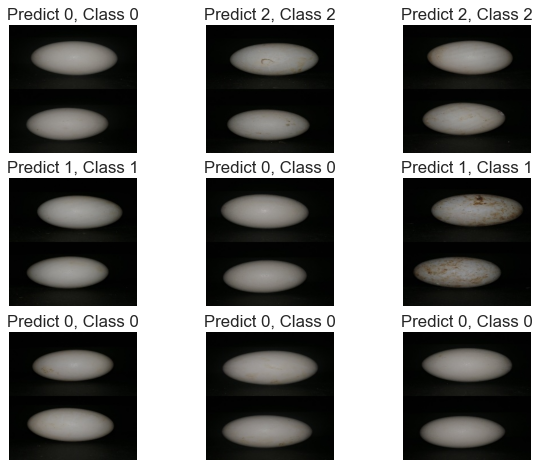

In [66]:
for x in range(len(yhat_classes_total)):
    print("Fold " + str(x+1))
    
    correct = np.where(yhat_classes_total[x]==yt)[0]

    print ("Found %d correct labels" % len(correct))

    print(correct[8])
    
    plt.figure(figsize=(10,8))
    for i, correct in enumerate(correct[:9]):
        plt.subplot(3,3,i+1)
        RGB_img = cv2.cvtColor(testX2[correct], cv2.COLOR_BGR2RGB)
        plt.imshow(RGB_img) #, interpolation='none') #, cmap='gray')
        plt.title("Predict {0}, Class {1}".format(str(yhat_classes_total[x][correct]),str(yt.values[correct])))
        plt.grid(False)
        plt.axis('off')
    
    plt.show()

### Incorrect predictions

Fold 1
Found 8 incorrect labels


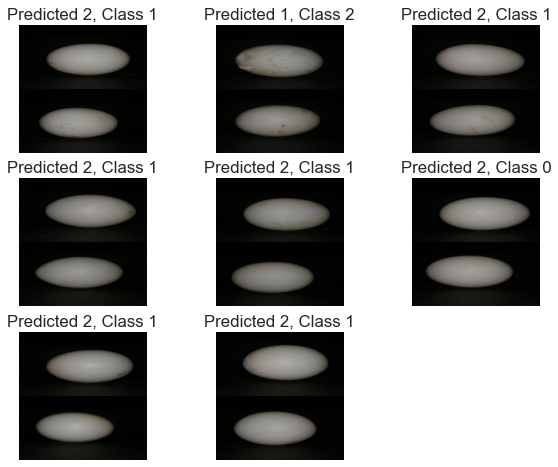

Fold 2
Found 11 incorrect labels


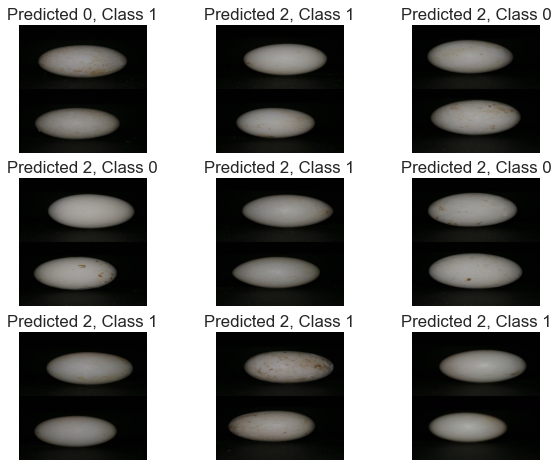

Fold 3
Found 13 incorrect labels


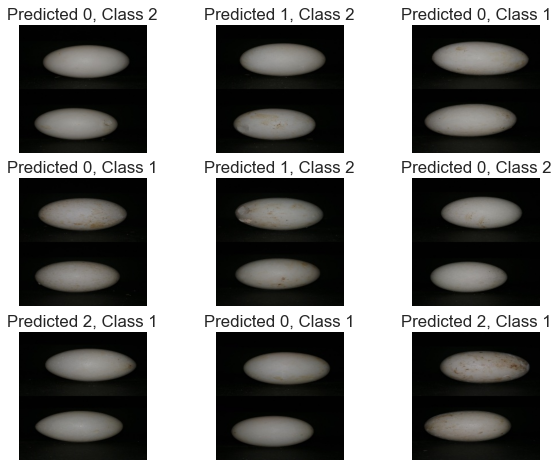

Fold 4
Found 11 incorrect labels


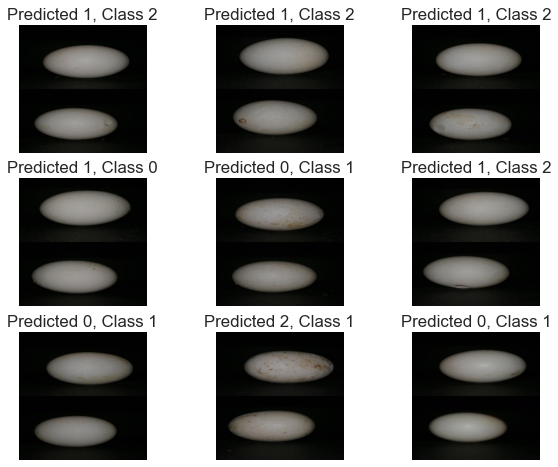

Fold 5
Found 6 incorrect labels


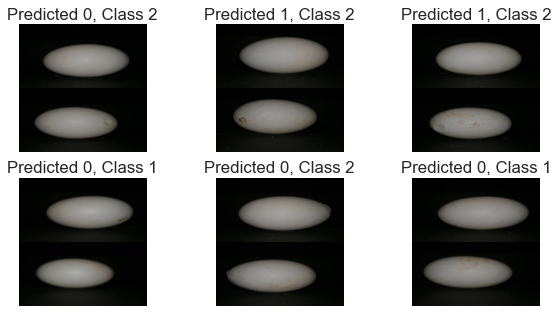

In [67]:
for x in range(len(yhat_classes_total)):
    print("Fold " + str(x+1))
    
    incorrect = np.where(yhat_classes_total[x]!=yt)[0]
    
    print ("Found %d incorrect labels" % len(incorrect))
    
    plt.figure(figsize=(10,8))
    for i, incorrect in enumerate(incorrect[:9]):
        plt.subplot(3,3,i+1)
        RGB_img = cv2.cvtColor(testX2[incorrect], cv2.COLOR_BGR2RGB)
        plt.imshow(RGB_img) #, interpolation='none') #, cmap='gray')
        plt.title("Predicted {0}, Class {1}".format(str(yhat_classes_total[x][incorrect]), str(yt.values[incorrect])))
        plt.grid(False)
        plt.axis('off')
    
    plt.show()